Here I have implemented Active learning on CIFAR10 dataset using ResNet18 as the base model. We currently use the following active learning strategies:
- Diversity acquisition
- Random acquisition

and compare their performance.

Reference Paper: [link](https://arxiv.org/abs/1708.00489), Reference Notebook: [link](https://github.com/nipunbatra/pml-teaching/blob/master/notebooks/ssl.ipynb)

<img src="../images/diversity_acq_AL/diversity_al_image.png" width="700">

# Intuition behind Diversity Active Learning
We want to select the most uncertain samples from the unlabeled pool. However, we also want to ensure that the selected samples are diverse. This is because if we select similar samples, we will not be able to learn much from them. 

Here we wish to work on images, so we can use their latent representation to select a pool point which is furthest in the latent dimension space from the train data.

Let's see how we can do this. Below is an example of random points in 2D space. We want to select the point which is furthest from the train data. We can do this by finding the point which has the maximum distance from the train data. This is the intuition behind diversity acquisition.

Importing the required libraries and modules.


In [1]:
try:
    from astra.torch.models import ResNetClassifier
    print('installed') 
except:
    print('not installed')
    pass
    %pip install git+https://github.com/sustainability-lab/ASTRA

installed


In [2]:
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
%matplotlib inline
# Retina display
%config InlineBackend.figure_format = 'retina'

# Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import torchsummary
from tqdm import tqdm

import umap

# ASTRA
from astra.torch.data import load_cifar_10
from astra.torch.utils import train_fn
from astra.torch.models import ResNetClassifier
from astra.torch.al import Furthest, Centroid, DiversityStrategy, UniformRandomAcquisition, RandomStrategy
# Netron, ONNX for model visualization
import netron
import onnx


/home/jaiswalsuraj/miniconda3/envs/torch_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/jaiswalsuraj/suraj_work/ASTRA/astra/torch/data.py:12: UserWarning: TORCH_HOME not set, setting it to /home/jaiswalsuraj/.cache/torch
  warnings.warn(f"TORCH_HOME not set, setting it to {os.environ['TORCH_HOME']}")


In [3]:
device = torch.device("cuda:2")
current_device = device #torch.cuda.current_device()
device_name = torch.cuda.get_device_name(current_device)
print(f"Current GPU assigned: {current_device}, Name: {device_name}, {device}")

Current GPU assigned: cuda:2, Name: NVIDIA A100-SXM4-80GB, cuda:2


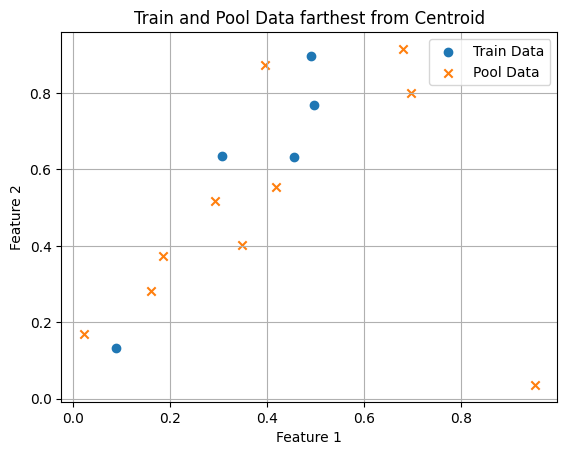

In [ ]:
# Create dummy data
n_train = 5
n_pool = 10
n_features = 2
torch.manual_seed(0)
# Generate random train and pool features
train_features = torch.rand(n_train, n_features)
pool_features = torch.rand(n_pool, n_features)

plt.scatter(train_features[:, 0], train_features[:, 1], label='Train Data', marker='o')
plt.scatter(pool_features[:, 0], pool_features[:, 1], label='Pool Data', marker='x')

# plt.scatter(centroid_feature[0], centroid_feature[1], label='Centroid', marker='s', c='red')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('Train and Pool Data farthest from Centroid')
plt.grid()
plt.show()

In [ ]:
n_samples = 2 # number of samples to select from pool
acquisition = Furthest()
selected_indices = acquisition.acquire_scores(
                    train_features.cpu(), pool_features.cpu(), n=n_samples
                )
selected_indices 

[8, 9]

Index of the n farthest Pool Feature from train features: [8, 9]


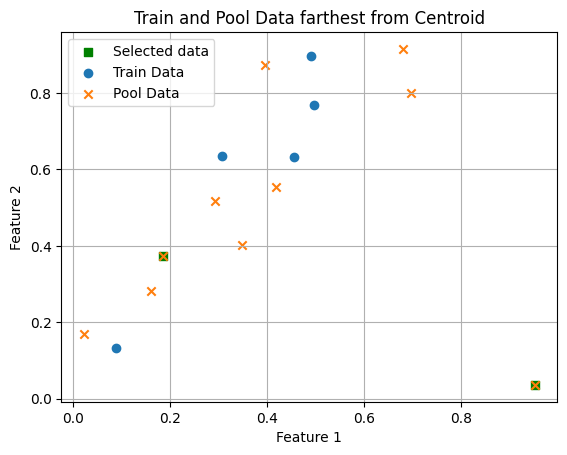

In [ ]:
print("Index of the n farthest Pool Feature from train features:", selected_indices)

plt.scatter(pool_features[selected_indices][:,0], pool_features[selected_indices][:,1], label='Selected data', marker='s', c='green')
plt.scatter(train_features[:, 0], train_features[:, 1], label='Train Data', marker='o')
plt.scatter(pool_features[:, 0], pool_features[:, 1], label='Pool Data', marker='x')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('Train and Pool Data farthest from Centroid')
plt.grid()
plt.show()

# CIFAR10 Dataset

let's now work on CIFAR10 dataset. 

In [4]:
dataset = load_cifar_10()
dataset 

Files already downloaded and verified
Files already downloaded and verified



CIFAR-10 Dataset
length of dataset: 60000
shape of images: torch.Size([3, 32, 32])
len of classes: 10
classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
dtype of images: torch.float32
dtype of labels: torch.int64
            

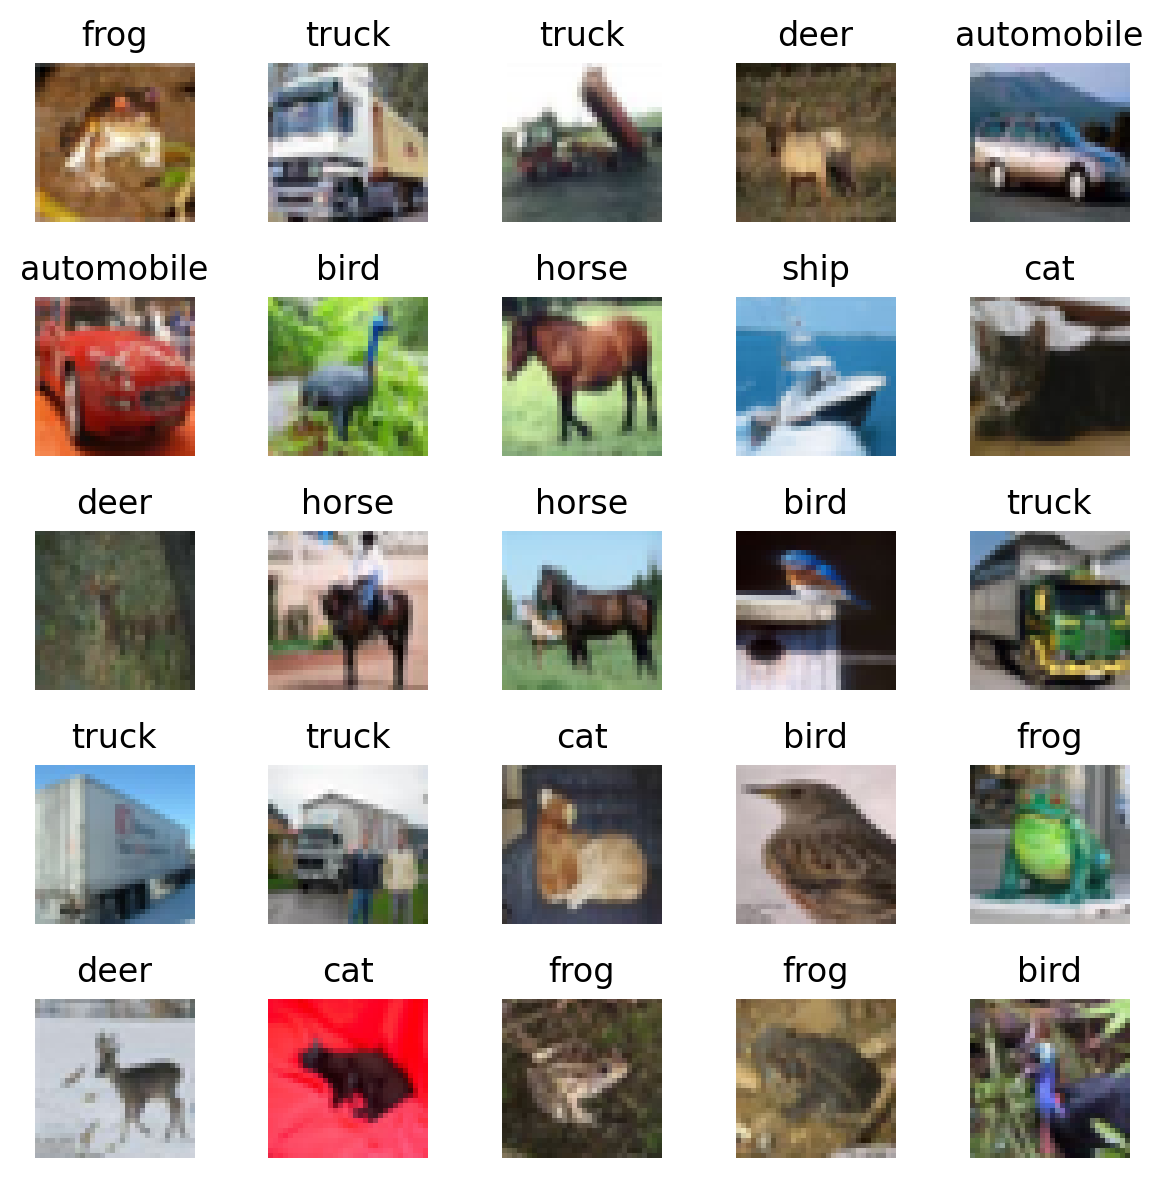

In [5]:
# Plot some images
plt.figure(figsize=(6, 6))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(torch.einsum("chw->hwc", dataset.data[i].cpu()))
    plt.axis('off')
    plt.title(dataset.classes[dataset.targets[i]])
plt.tight_layout()

## Train val test split

In [6]:
n_train = 1000
n_test = 20000

X = dataset.data.to(device)
y = dataset.targets.to(device)

print(X.shape)
print(X.shape, X.dtype)
print(X.min(), X.max())
print(y.shape, y.dtype)
print(X.device, y.device)

torch.Size([60000, 3, 32, 32])
torch.Size([60000, 3, 32, 32]) torch.float32
tensor(0., device='cuda:2') tensor(1., device='cuda:2')
torch.Size([60000]) torch.int64
cuda:2 cuda:2


In [7]:
torch.manual_seed(0)
idx = torch.randperm(len(X))
train_idx = idx[:n_train]
pool_idx = idx[n_train:-n_test]
test_idx = idx[-n_test:] 
print(len(train_idx), len(pool_idx), len(test_idx))

1000 39000 20000


# Without Active Learning

## Checking out untrained model

Before we start training the model, let's see how the model performs without training so we can get lowerbound on the performance of the model.

In [12]:
resnet = ResNetClassifier(models.resnet18, models.ResNet18_Weights.DEFAULT, n_classes=10).to(device)

In [18]:
# Export to ONNX and visualize with Netron
dummy_input = torch.randn(1, 3, 32, 32).to(device)
# torch.onnx.export(resnet, dummy_input, "resnet.onnx", verbose=True)
# netron.start("resnet.onnx")

In [16]:
accuracy_summary = {}

In [8]:
def get_accuracy(net, X, y):
    with torch.no_grad():
        logits_pred = net(X)
        y_pred = logits_pred.argmax(dim=1)
        acc = (y_pred == y).float().mean()
        return y_pred, acc

def predict(net, classes, plot_confusion_matrix=False, train_idx= train_idx, pool_idx=pool_idx, test_idx=test_idx):
    accuracies = {}
    for i, (name, idx) in enumerate(zip(("train", "pool", "test"), [train_idx, pool_idx, test_idx])):
        X_dataset = X[idx].to(device)
        y_dataset = y[idx].to(device)
        y_pred, acc = get_accuracy(net, X_dataset, y_dataset)
        accuracies[name] = acc.item() 
        print(f'{name} set accuracy: {acc*100:.2f}%')
        if plot_confusion_matrix:
            cm = confusion_matrix(y_dataset.cpu(), y_pred.cpu())
            cm_display = ConfusionMatrixDisplay(cm, display_labels=classes).plot(values_format='d'
                                                                                , cmap='Blues')
            # Rotate the labels on x-axis to make them readable
            _ = plt.xticks(rotation=90)
            plt.show() 
    return accuracies 

In [18]:
accuracy_summary['untrain_acc'] = predict(resnet, dataset.classes, plot_confusion_matrix=False)
accuracy_summary

train set accuracy: 7.70%


pool set accuracy: 8.37%
test set accuracy: 8.58%


{'untrain_acc': {'train': 0.07700000703334808,
  'pool': 0.08366666734218597,
  'test': 0.08579999953508377}}

In [9]:
def viz_embeddings(net, X, y, device):
    reducer = umap.UMAP()
    with torch.no_grad():
        emb = net.featurizer(X.to(device))
    emb = emb.cpu().numpy()
    emb = reducer.fit_transform(emb)
    plt.figure(figsize=(4, 4))
    plt.scatter(emb[:, 0], emb[:, 1], c=y.cpu().numpy(), cmap='tab10')
    # Add a colorbar legend to mark color to class mapping
    cb = plt.colorbar(boundaries=np.arange(11)-0.5)
    cb.set_ticks(np.arange(10))
    cb.set_ticklabels(dataset.classes)
    plt.title("UMAP embeddings")
    plt.tight_layout()

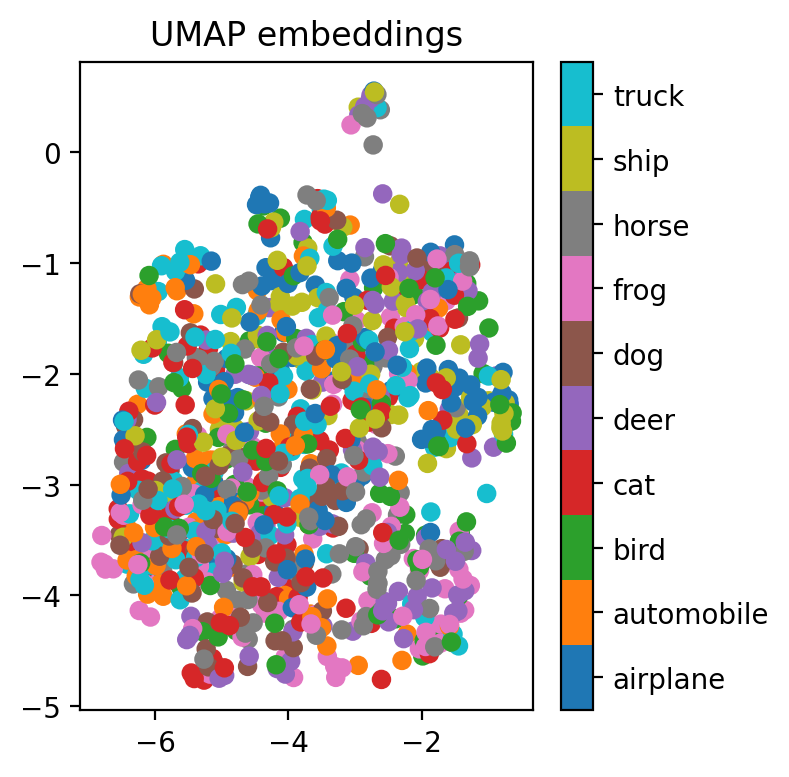

In [20]:
viz_embeddings(resnet, X[train_idx], y[train_idx], device)

## Train the model on labeled train set(1000)

In [21]:
resnet = ResNetClassifier(models.resnet18, None, n_classes=10, activation=nn.GELU(), dropout=0.1).to(device)
iter_losses, epoch_losses = train_fn(resnet, X[train_idx], y[train_idx], nn.CrossEntropyLoss(), lr=3e-4, 
                                     batch_size=128, epochs=30, verbose=False)

Text(0, 0.5, 'Training loss')

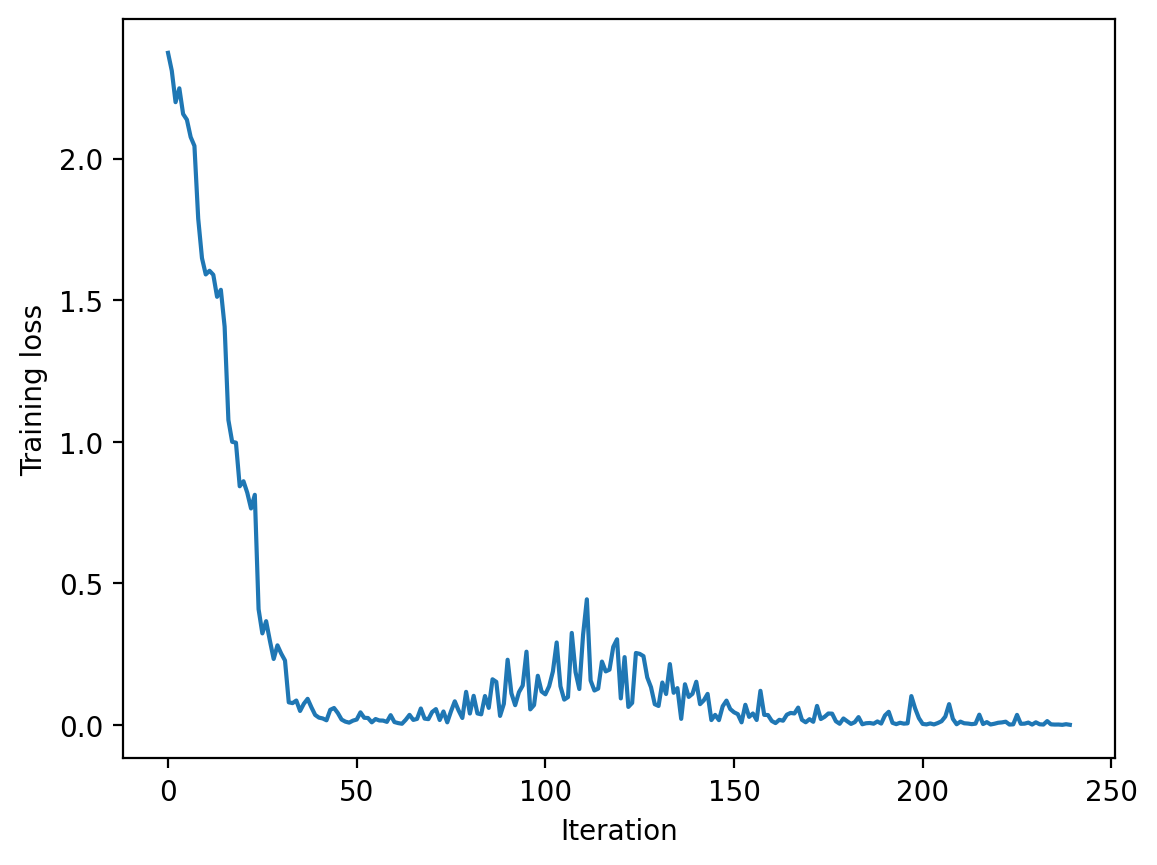

In [22]:
plt.plot(iter_losses)
plt.xlabel("Iteration")
plt.ylabel("Training loss")

train set accuracy: 100.00%


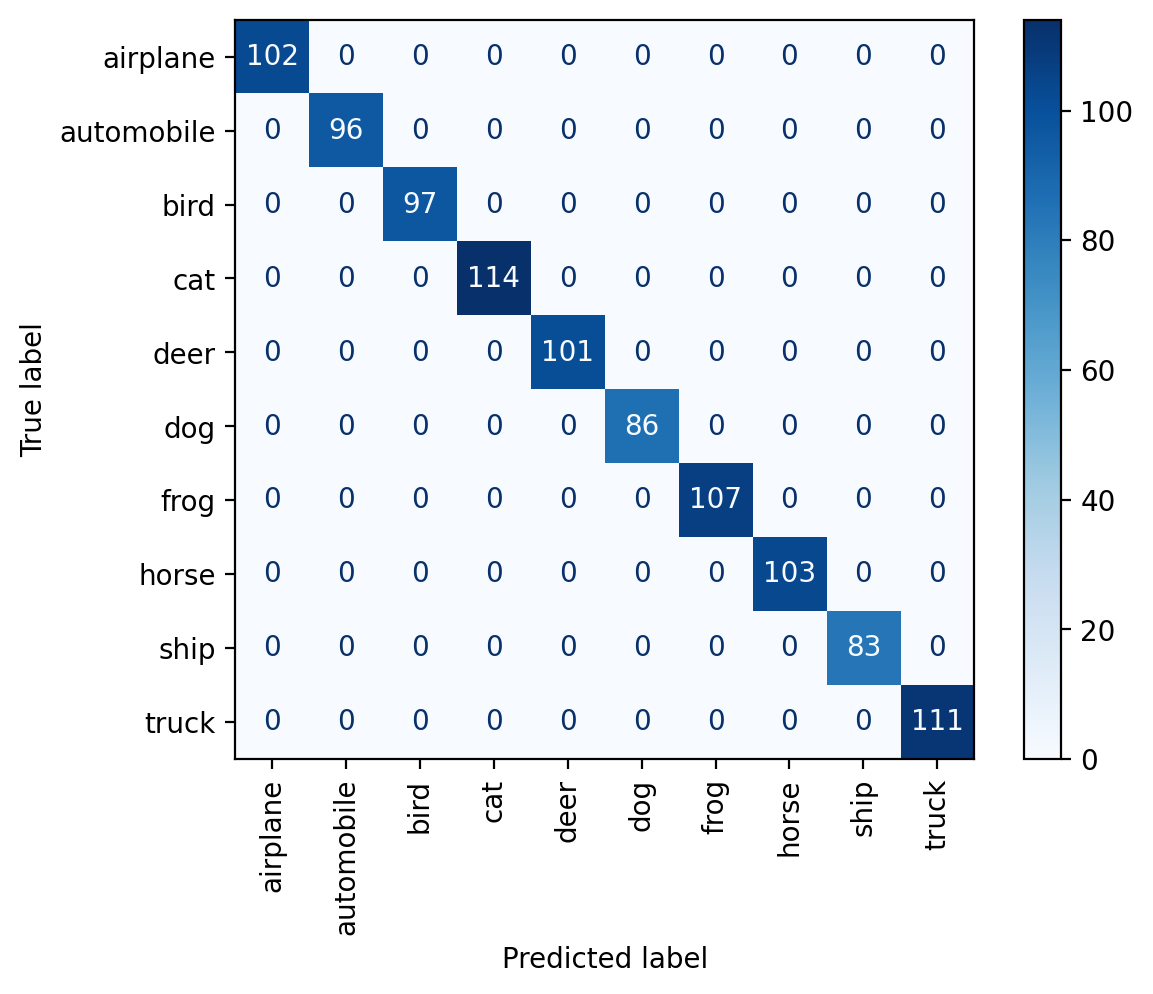

pool set accuracy: 36.06%


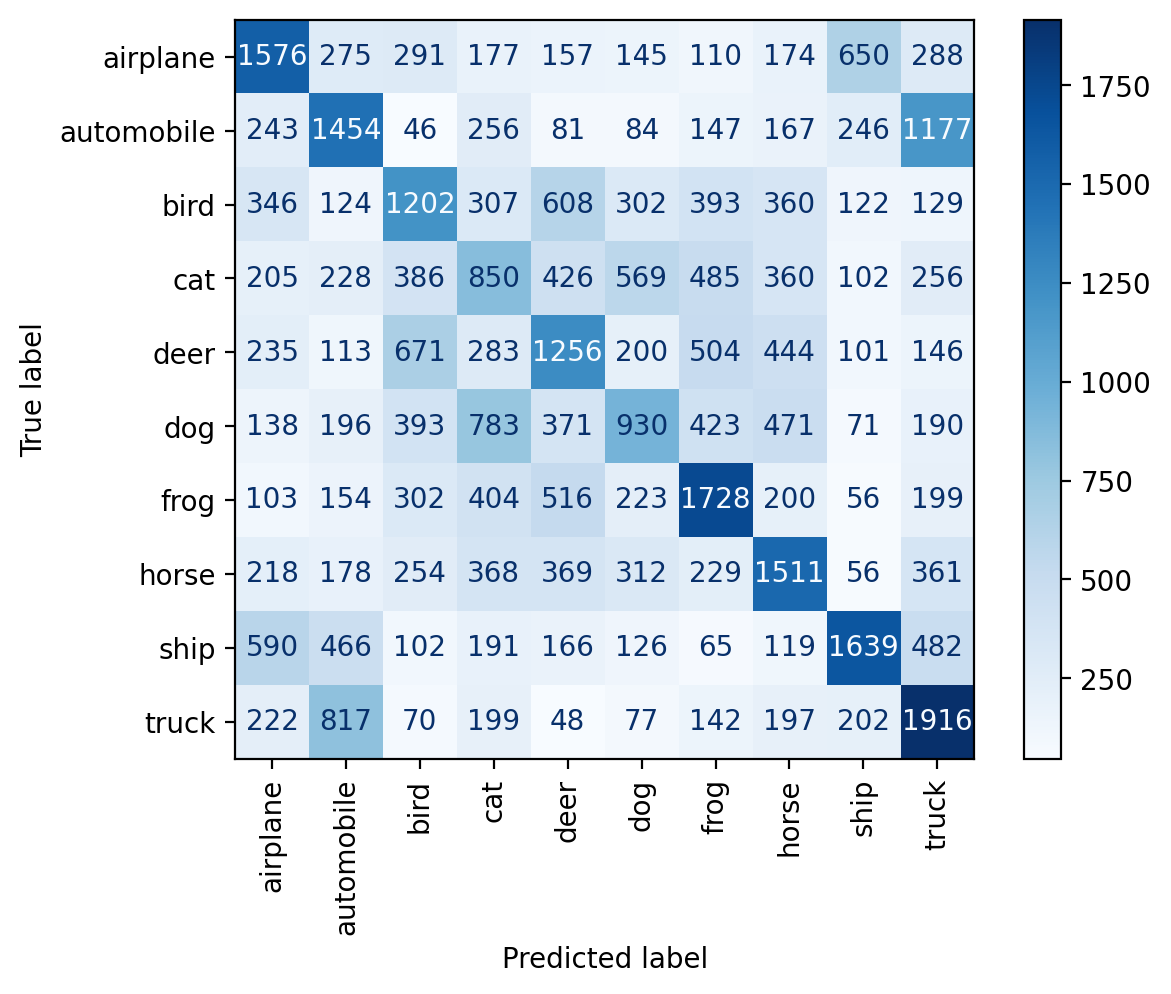

test set accuracy: 36.24%


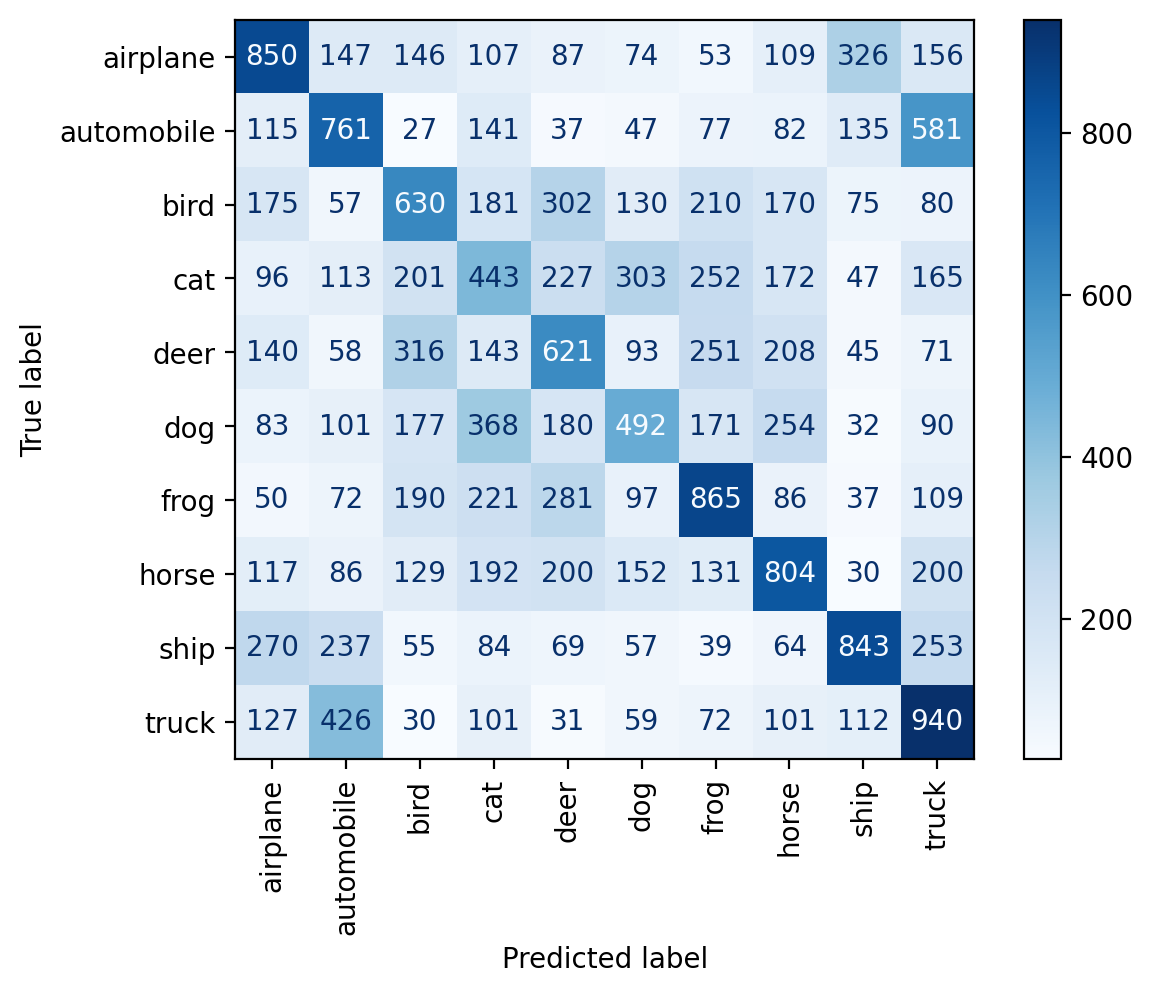

In [23]:
accuracy_summary["train_1000"] = predict(resnet, dataset.classes, plot_confusion_matrix=True)

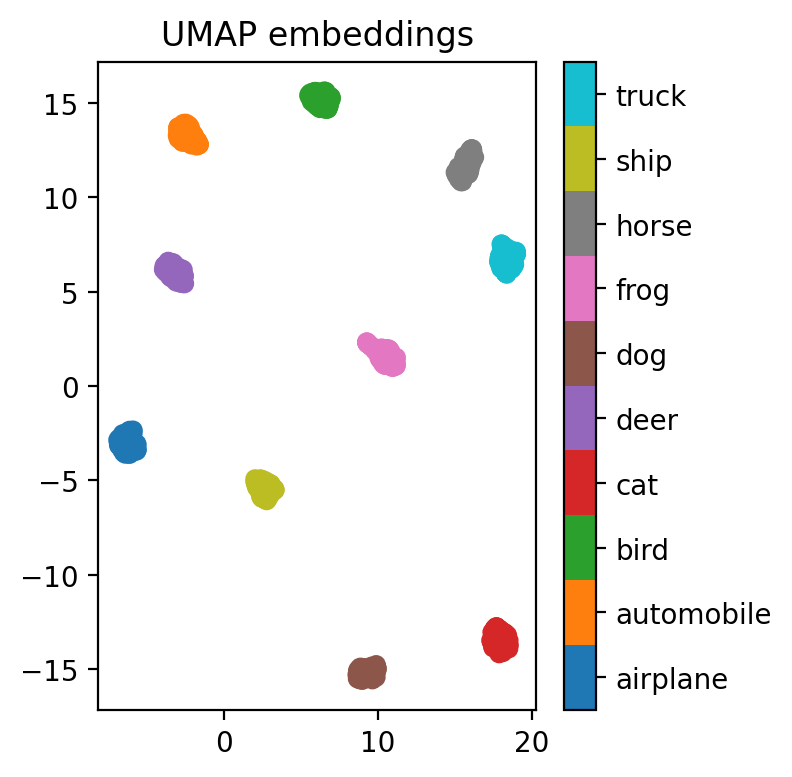

In [24]:
viz_embeddings(resnet, X[train_idx], y[train_idx], device)

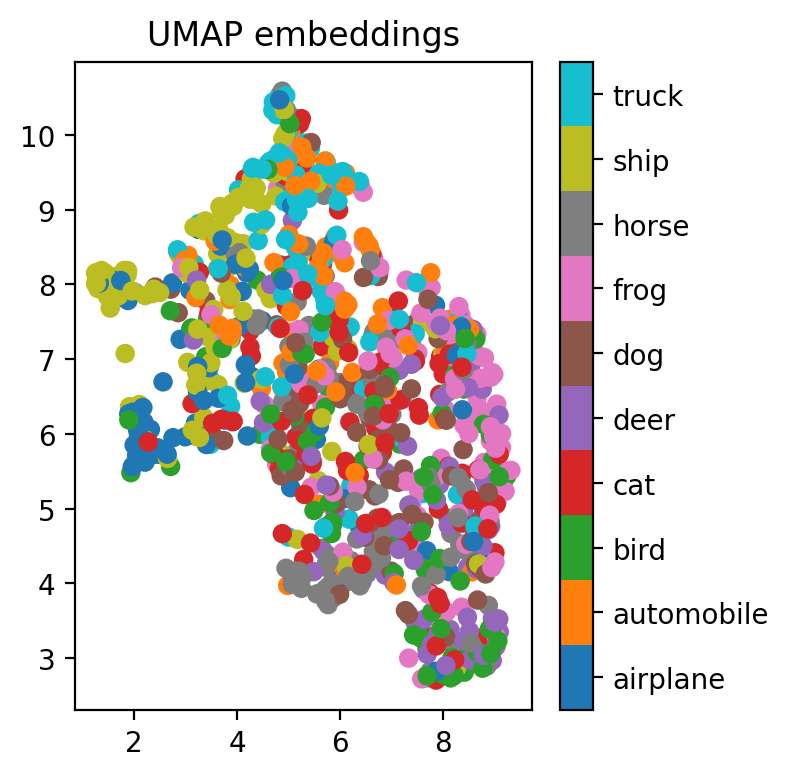

In [25]:
viz_embeddings(resnet, X[test_idx[:1000]], y[test_idx[:1000]], device)

In [26]:
accuracy_summary

{'untrain_acc': {'train': 0.07700000703334808,
  'pool': 0.08366666734218597,
  'test': 0.08579999953508377},
 'train_1000': {'train': 1.0,
  'pool': 0.36056411266326904,
  'test': 0.3624500036239624}}

## Train on train labeled(1000)+ labeled pool(5000)

In [27]:
torch.manual_seed(0)
idx = torch.randperm(len(X))
train_idx = idx[:n_train]
pool_idx = idx[n_train:-n_test]
test_idx = idx[-n_test:] 

### Train on train + pool
train_plus_pool_idx = torch.cat([train_idx, pool_idx[:5000]])
print(train_plus_pool_idx.shape)
resnet = ResNetClassifier(models.resnet18, None, n_classes=10, activation=nn.GELU(), dropout=0.1).to(device)

iter_losses, epoch_losses = train_fn(resnet, X[train_plus_pool_idx], y[train_plus_pool_idx], loss_fn=nn.CrossEntropyLoss(),
                                        lr=3e-4,
                                        batch_size=1024, epochs=30, verbose=False)

torch.Size([6000])


Text(0, 0.5, 'Training loss')

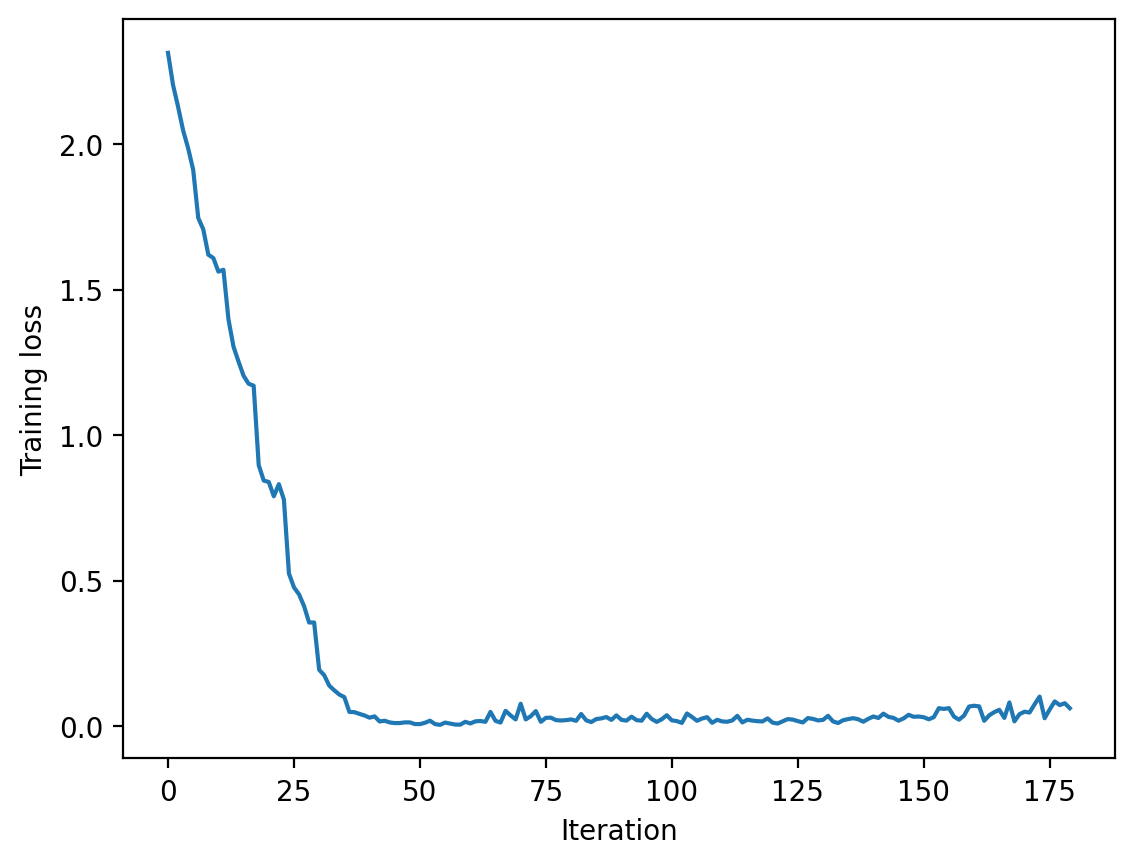

In [28]:
plt.plot(iter_losses)   
plt.xlabel("Iteration")
plt.ylabel("Training loss") 

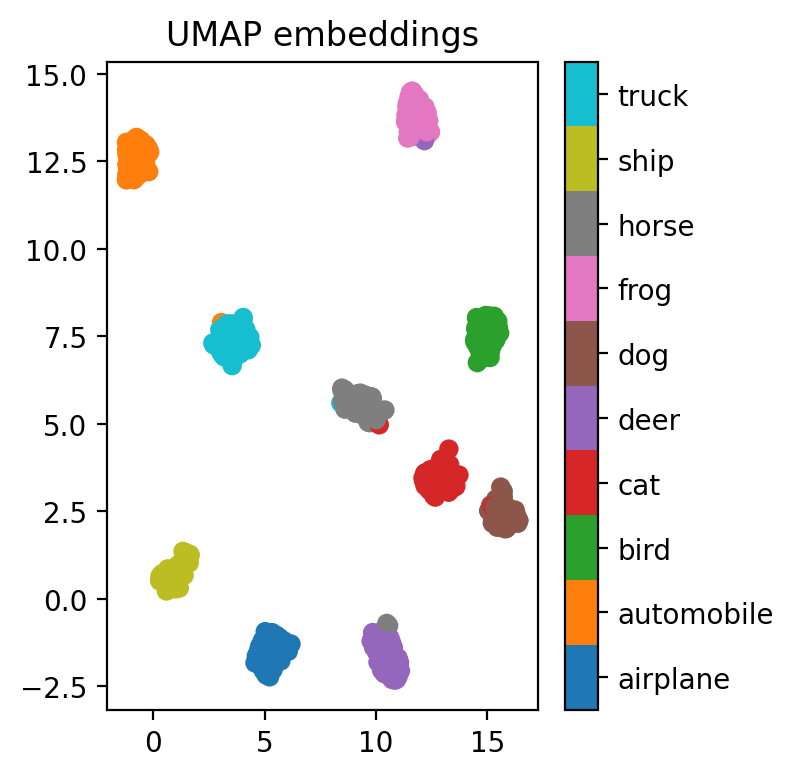

In [29]:
viz_embeddings(resnet, X[train_idx], y[train_idx], device)

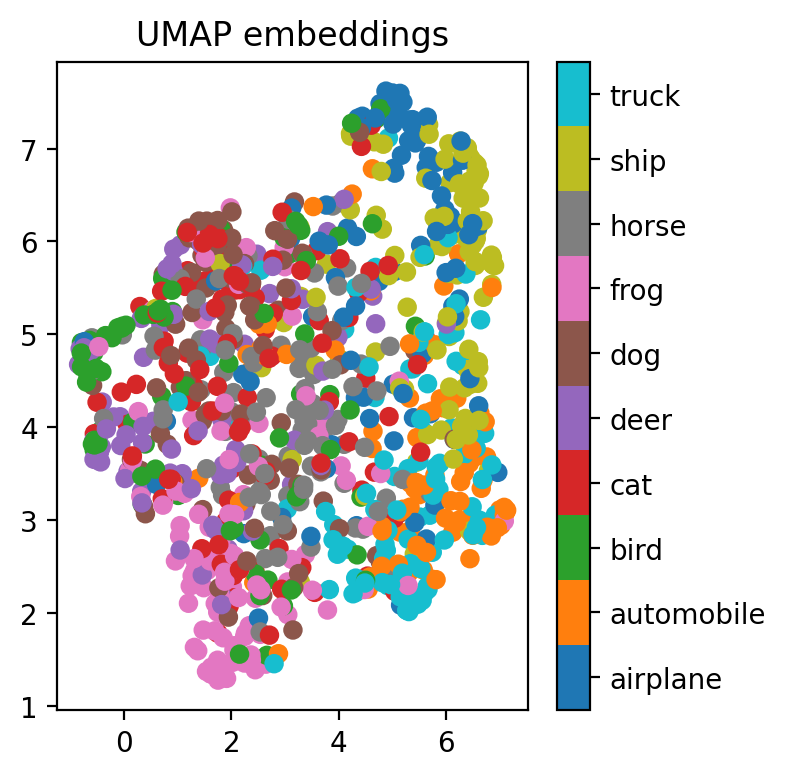

In [30]:
viz_embeddings(resnet, X[test_idx[:1000]], y[test_idx[:1000]], device)

train set accuracy: 99.20%


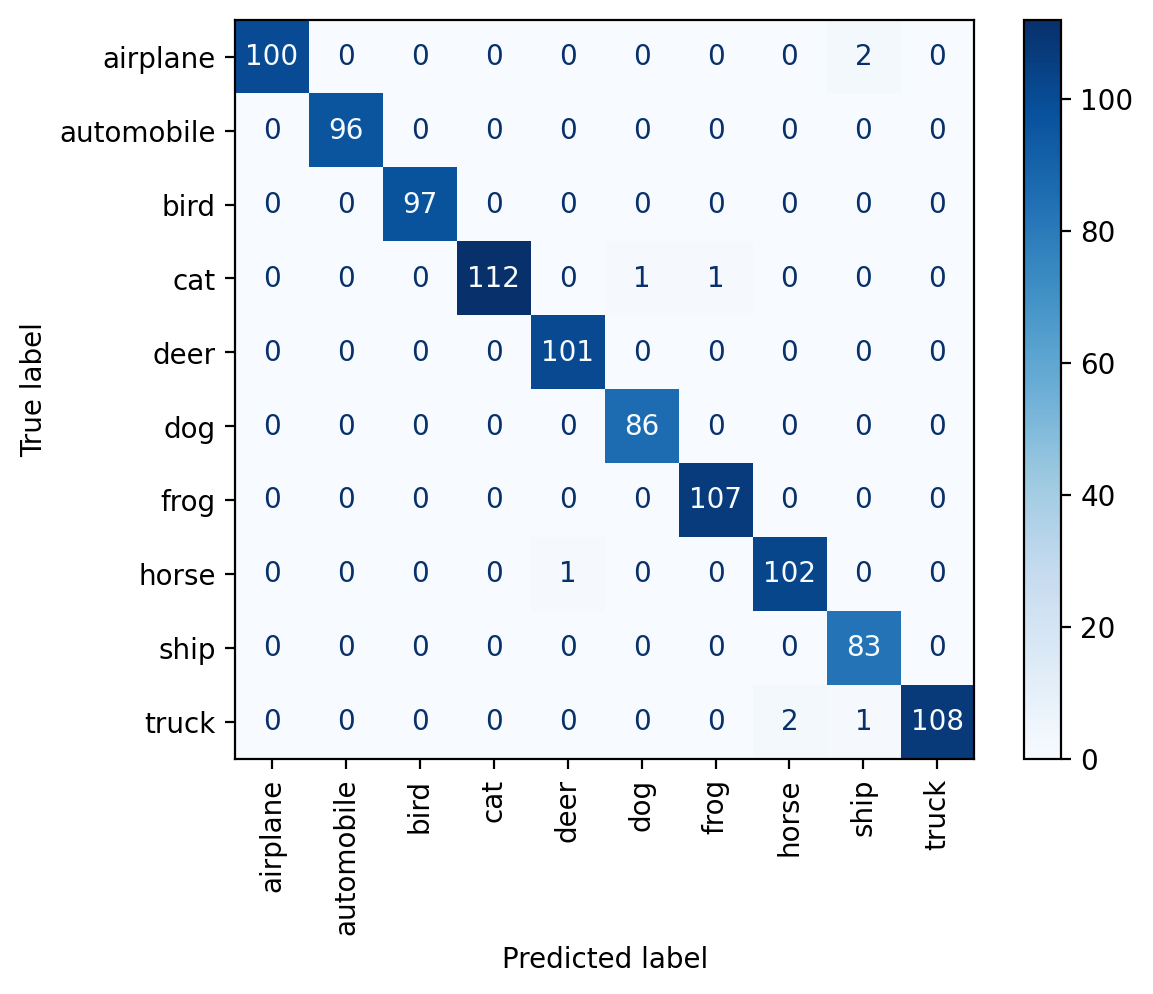

pool set accuracy: 49.98%


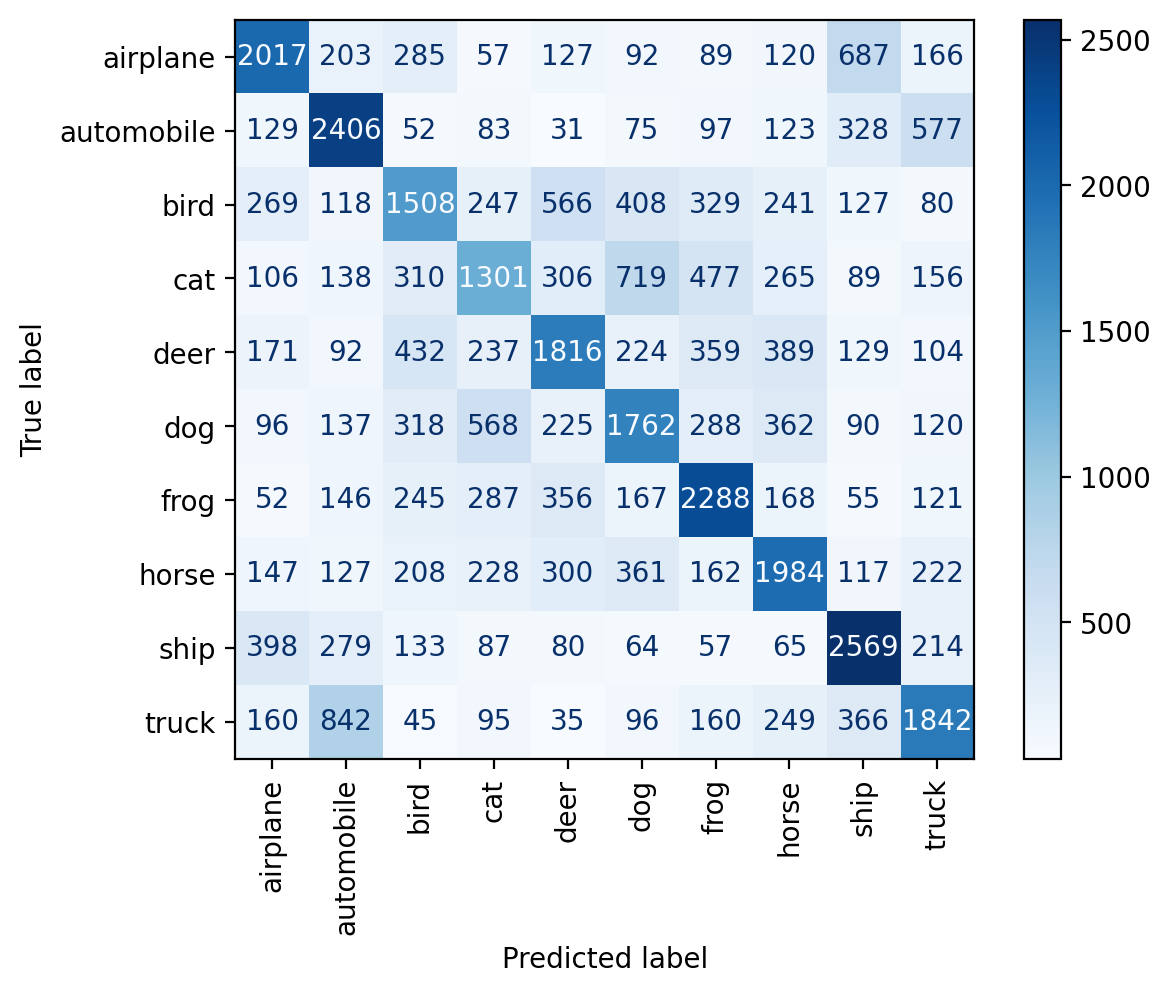

test set accuracy: 42.73%


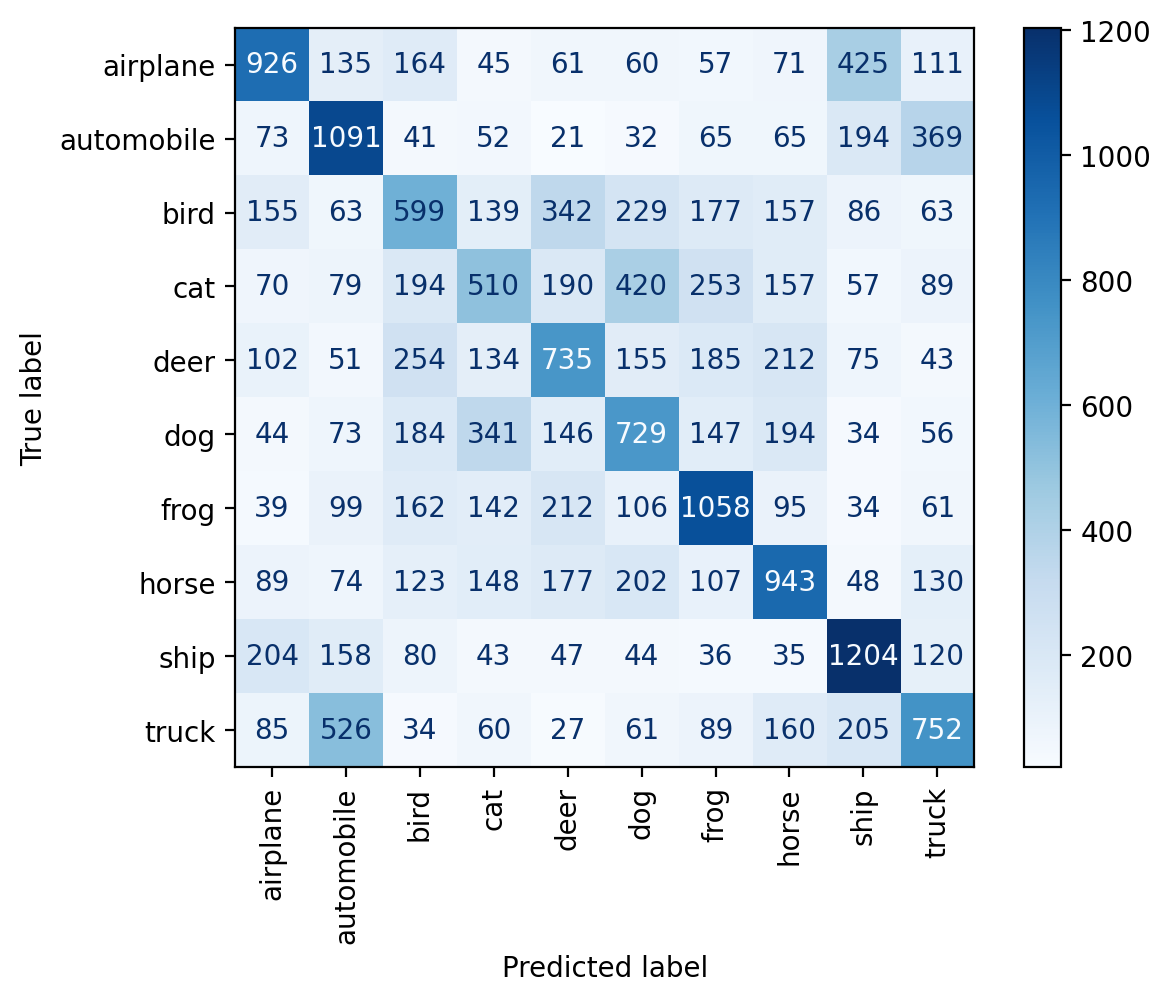

In [31]:
# predict(resnet, dataset.classes, plot_confusion_matrix=True)
accuracy_summary["train_1000_pool_5000"] = predict(resnet, dataset.classes, plot_confusion_matrix=True)

## Train on labled train(1000) + labeled pool whole(39000)

In [32]:
torch.manual_seed(0)
idx = torch.randperm(len(X))
train_idx = idx[:n_train]
pool_idx = idx[n_train:-n_test]
test_idx = idx[-n_test:] 

### Train on train + pool
train_plus_pool_idx = torch.cat([train_idx, pool_idx])

resnet = ResNetClassifier(models.resnet18, None, n_classes=10, activation=nn.GELU(), dropout=0.1).to(device)

iter_losses, epoch_losses = train_fn(resnet, X[train_plus_pool_idx], y[train_plus_pool_idx], loss_fn=nn.CrossEntropyLoss(),
                                     lr=3e-4,
                                        batch_size=1024, epochs=30, verbose=False)

Text(0, 0.5, 'Training loss')

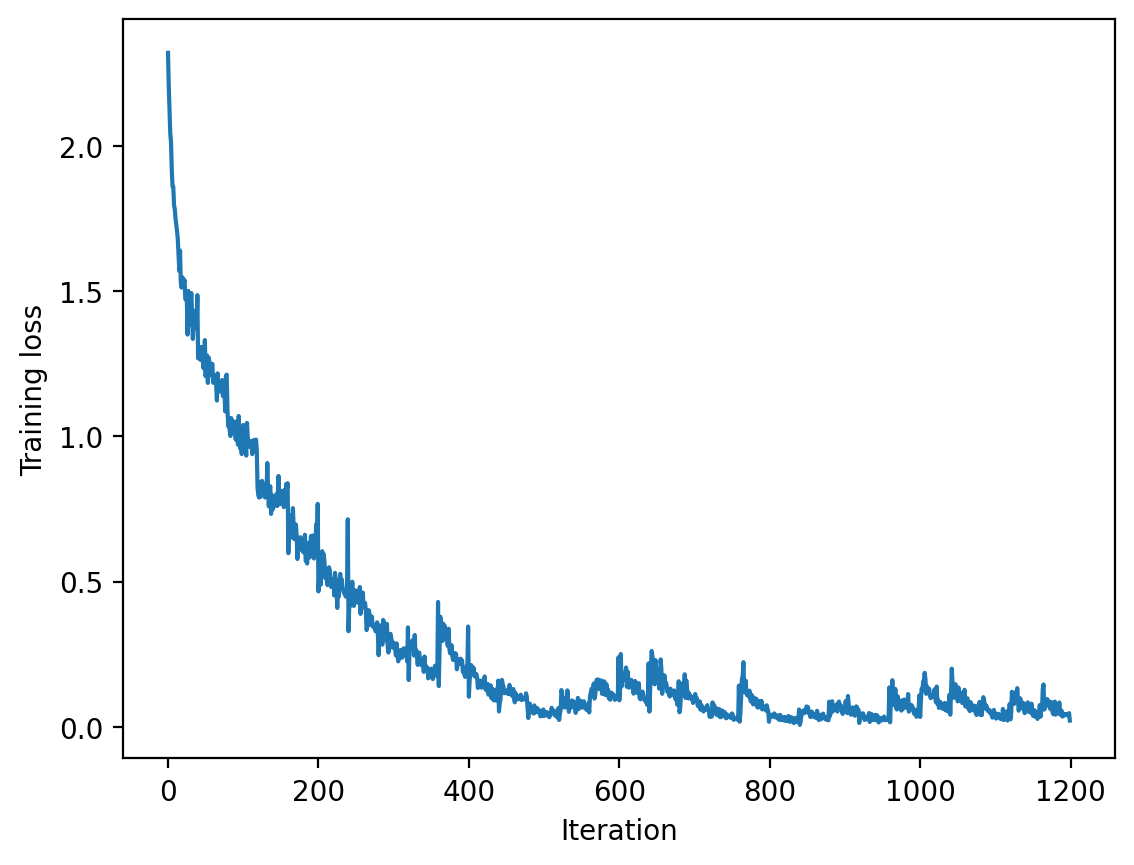

In [33]:
plt.plot(iter_losses)   
plt.xlabel("Iteration")
plt.ylabel("Training loss")

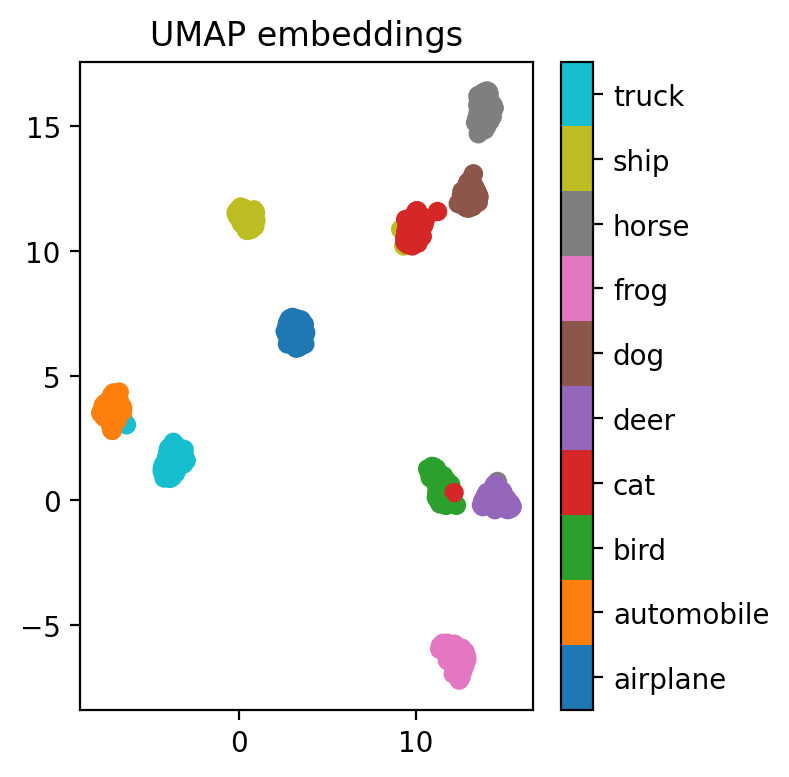

In [34]:
viz_embeddings(resnet, X[train_idx], y[train_idx], device)

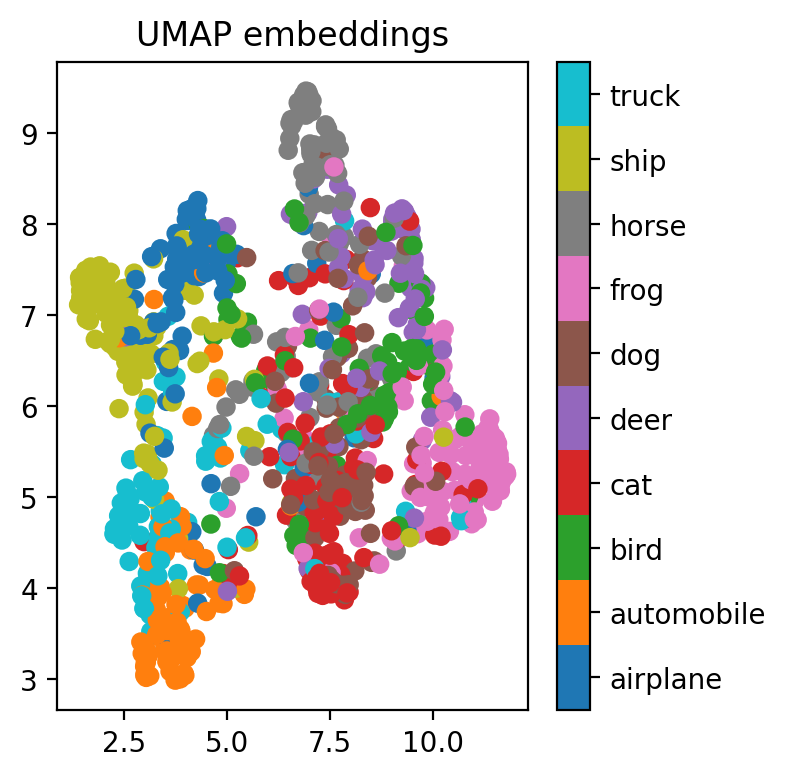

In [35]:
viz_embeddings(resnet, X[test_idx[:1000]], y[test_idx[:1000]], device)

train set accuracy: 99.60%


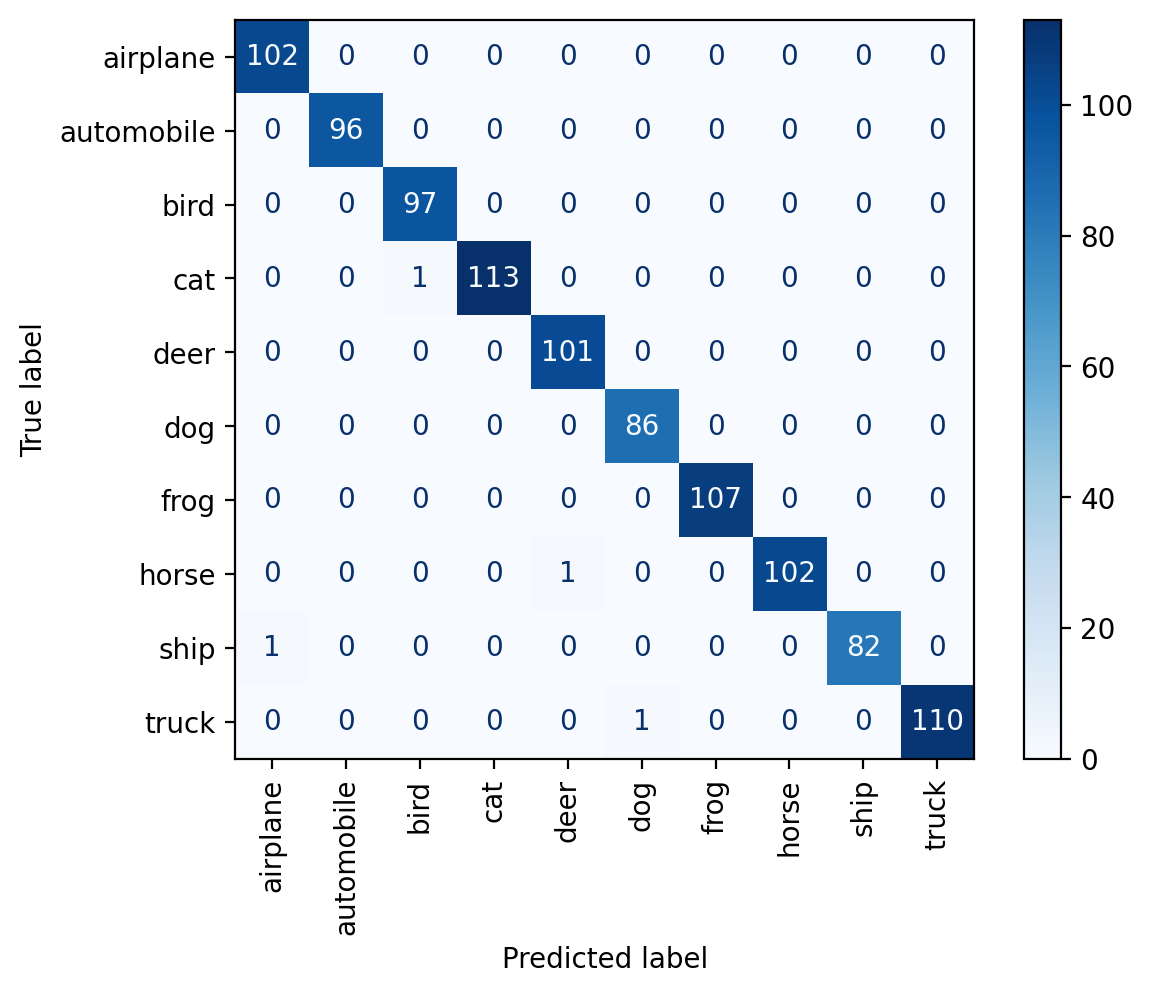

pool set accuracy: 99.43%


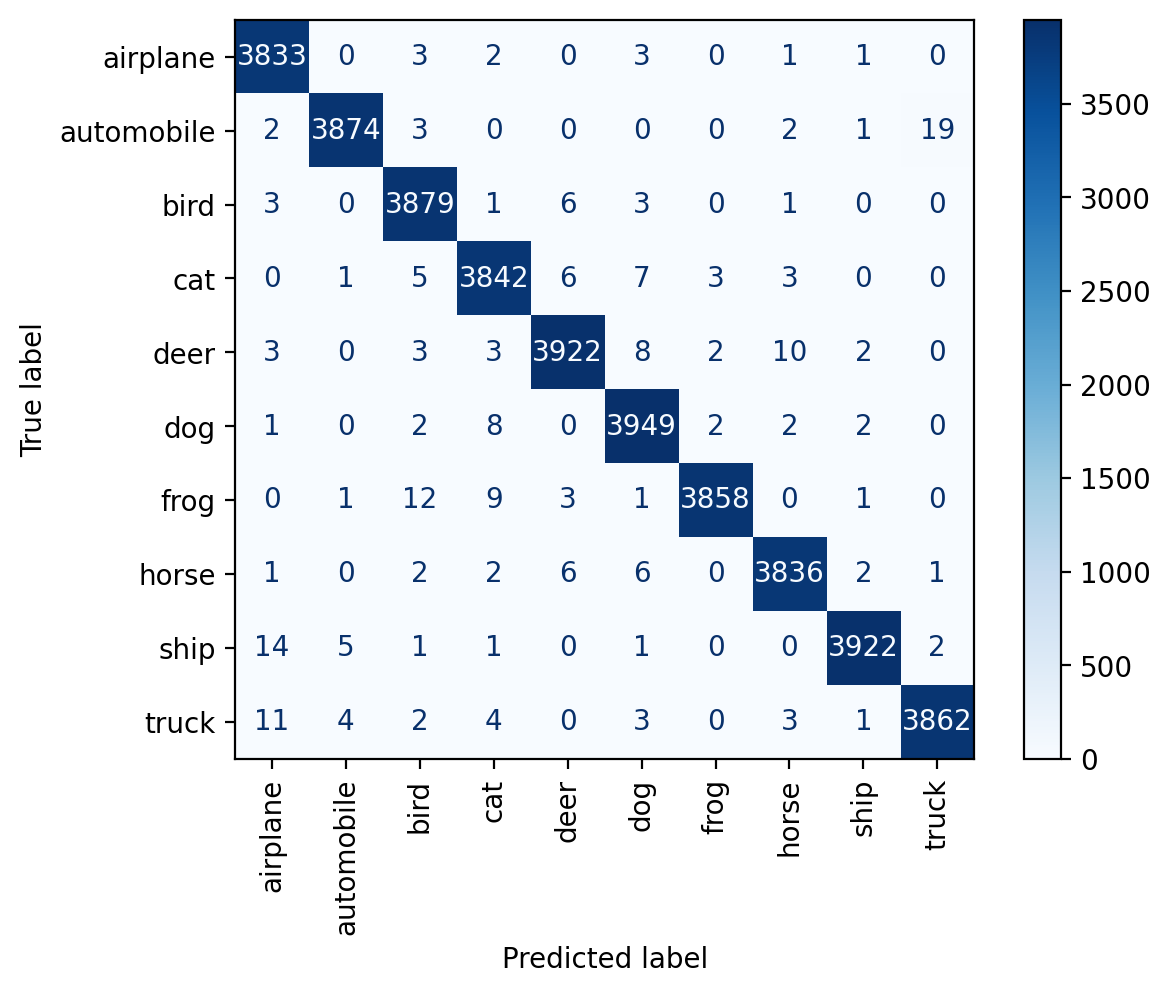

test set accuracy: 61.61%


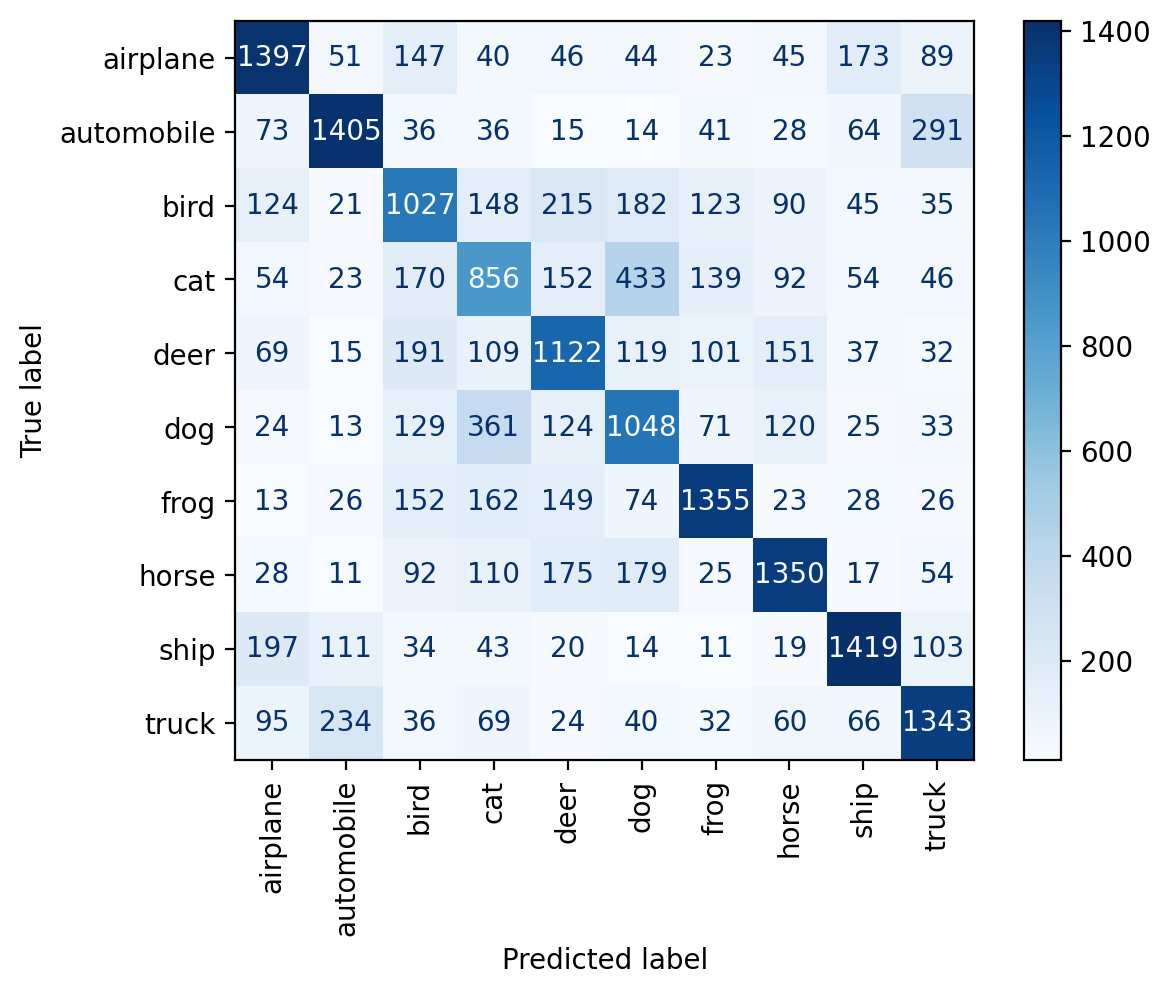

In [36]:
accuracy_summary[f"train_1000_pool_39000"] = predict(resnet, dataset.classes, plot_confusion_matrix=True)

In [37]:
accuracy_summary 

{'untrain_acc': {'train': 0.07700000703334808,
  'pool': 0.08366666734218597,
  'test': 0.08579999953508377},
 'train_1000': {'train': 1.0,
  'pool': 0.36056411266326904,
  'test': 0.3624500036239624},
 'train_1000_pool_5000': {'train': 0.9920000433921814,
  'pool': 0.4998205304145813,
  'test': 0.4273499846458435},
 'train_1000_pool_39000': {'train': 0.9960000514984131,
  'pool': 0.994282066822052,
  'test': 0.616100013256073}}

loading accuracy results

In [38]:
# import json
# file_path = "/home/jaiswalsuraj/suraj_work/ASTRA/notebooks/al/accuracy_summary_without.json"

# with open(file_path, 'w') as json_file:
#     json.dump(accuracy_summary, json_file)

# print(f"Accuracy summary has been saved to {file_path}.")

Accuracy summary has been saved to /home/jaiswalsuraj/suraj_work/ASTRA/notebooks/al/accuracy_summary_without.json.


In [10]:
file_path = "/home/jaiswalsuraj/suraj_work/ASTRA/notebooks/al/accuracy_summary_without.json"

# Load the accuracy summary from the JSON file
with open(file_path, 'r') as json_file:
    accuracy_summary = json.load(json_file)

In [11]:
accuracy_summary 

{'untrain_acc': {'train': 0.07700000703334808,
  'pool': 0.08366666734218597,
  'test': 0.08579999953508377},
 'train_1000': {'train': 1.0,
  'pool': 0.36056411266326904,
  'test': 0.3624500036239624},
 'train_1000_pool_5000': {'train': 0.9920000433921814,
  'pool': 0.4998205304145813,
  'test': 0.4273499846458435},
 'train_1000_pool_39000': {'train': 0.9960000514984131,
  'pool': 0.994282066822052,
  'test': 0.616100013256073}}

# Active Learning for Convolutional Neural Networks: A Core-Set Approach
Paper [link](https://arxiv.org/abs/1708.00489)

In [10]:
torch.manual_seed(0)
idx = torch.randperm(len(X))
train_idx = idx[:n_train]
pool_idx = idx[n_train:-n_test]
test_idx = idx[-n_test:] 

accuracy_AL_list = {}
class_count_dict = {}

In [11]:
def AL_loop(train_idx, pool_idx, strategy, acquisition, n_query_samples, num_iter):
    train_idx_copy = train_idx.clone().to(device)
    pool_idx_copy = pool_idx.clone().to(device)

    n_query_samples = n_query_samples # Number of samples to add to training set at each iteration
    num_iter = num_iter # Number of iterations to run active learning for
    accuracy_list = [] # List to store accuracies
    class_count_list = [] # List to store class counts
    for i in trange(num_iter):
        resnet = ResNetClassifier(models.resnet18, None, n_classes=10, activation=nn.GELU(), dropout=0.1).to(device)
        iter_losses, epoch_losses = train_fn(resnet, X[train_idx_copy], y[train_idx_copy], nn.CrossEntropyLoss(), lr=3e-4, 
                                        batch_size=128, epochs=30, verbose=False)
        
        if strategy.__class__.__name__ == 'DiversityStrategy':
            best_indices = strategy.query(
                resnet.featurizer, pool_idx_copy.to(device), train_idx_copy.to(device), n_query_samples=n_query_samples
            )
        elif strategy.__class__.__name__== 'RandomStrategy':
            best_indices = strategy.query(
                resnet, pool_idx_copy.to(device), n_query_samples=n_query_samples
            )
        else:
            print('Invalid strategy')
            return
        accuracy_list.append(predict(resnet, dataset.classes, plot_confusion_matrix=False, train_idx=train_idx_copy, pool_idx=pool_idx_copy, test_idx=test_idx))
        class_counts = torch.bincount(y[train_idx_copy], minlength=len(dataset.classes))
        class_count_list.append(class_counts) 
        # print(train_idx_copy.device, pool_idx_copy.device, best_indices[acquisition.__class__.__name__].device)
        train_idx_copy = torch.cat([train_idx_copy, best_indices[acquisition.__class__.__name__]])
        # pool_idx_copy = torch.cat([pool_idx_copy[i:i + 1] for i in range(len(pool_idx_copy)) if i not in best_indices[acquisition.__class__.__name__]], dim=0)
        pool_idx_copy = pool_idx_copy[~torch.isin(pool_idx_copy, best_indices[acquisition.__class__.__name__])]
    class_counts = torch.bincount(y[train_idx_copy], minlength=len(dataset.classes))
    class_count_list.append(class_counts)
    accuracy_list.append(predict(resnet, dataset.classes, plot_confusion_matrix=False, train_idx=train_idx_copy, pool_idx=pool_idx_copy, test_idx=test_idx))
    
    print('train length: ', train_idx_copy.shape,'pool lenght: ', pool_idx_copy.shape)
    selected_idx = train_idx_copy 
    return accuracy_list, accuracy_list[-1], class_count_list # returns accuracy list(over al iterations) and accuracy at end(train, pool, test)

## Furtherst acquistion Strategy

In [44]:
acquisition = Furthest()
strategy = DiversityStrategy(acquisition, X, y)

strategy.to(device)

seeds = [0 ]#, 1, 2, 3, 4]
for seed in seeds: 
    print(strategy.__class__.__name__, ' For seed: ', seed, ' ----------------------------------------- ')
    n_query_samples = 100
    num_iter = 50
    a, b, c = AL_loop(train_idx, pool_idx, strategy, acquisition, n_query_samples = n_query_samples, num_iter = num_iter)
    accuracy_AL_list[f"train_1000_pool_query_{n_query_samples}_iter_{num_iter}_{strategy.__class__.__name__}_seed_{seed}"] = a
    accuracy_summary[f"train_1000_pool_query_{n_query_samples}_iter_{num_iter}_{strategy.__class__.__name__}_seed_{seed}"] = b 
    class_count_dict[f"train_1000_pool_query_{n_query_samples}_iter_{num_iter}_{strategy.__class__.__name__}_seed_{seed}"] = c

DiversityStrategy  For seed:  0  ----------------------------------------- 


  0%|          | 0/50 [00:00<?, ?it/s]

train set accuracy: 100.00%


  2%|▏         | 1/50 [00:04<03:44,  4.58s/it]

pool set accuracy: 36.18%
test set accuracy: 36.43%
train set accuracy: 100.00%


  4%|▍         | 2/50 [00:09<03:48,  4.76s/it]

pool set accuracy: 36.20%
test set accuracy: 36.69%
train set accuracy: 100.00%


  6%|▌         | 3/50 [00:14<03:55,  5.02s/it]

pool set accuracy: 37.16%
test set accuracy: 37.14%
train set accuracy: 99.54%


  8%|▊         | 4/50 [00:20<04:02,  5.27s/it]

pool set accuracy: 36.48%
test set accuracy: 36.71%
train set accuracy: 100.00%


 10%|█         | 5/50 [00:26<04:04,  5.43s/it]

pool set accuracy: 38.77%
test set accuracy: 38.72%
train set accuracy: 100.00%


 12%|█▏        | 6/50 [00:32<04:08,  5.64s/it]

pool set accuracy: 39.10%
test set accuracy: 39.38%
train set accuracy: 100.00%


 14%|█▍        | 7/50 [00:38<04:13,  5.91s/it]

pool set accuracy: 39.21%
test set accuracy: 39.09%
train set accuracy: 99.82%


 16%|█▌        | 8/50 [00:45<04:19,  6.18s/it]

pool set accuracy: 38.07%
test set accuracy: 38.21%
train set accuracy: 99.61%


 18%|█▊        | 9/50 [00:52<04:27,  6.52s/it]

pool set accuracy: 38.90%
test set accuracy: 39.38%
train set accuracy: 100.00%


 20%|██        | 10/50 [00:59<04:29,  6.74s/it]

pool set accuracy: 39.75%
test set accuracy: 39.89%
train set accuracy: 100.00%


 22%|██▏       | 11/50 [01:07<04:31,  6.96s/it]

pool set accuracy: 39.51%
test set accuracy: 39.52%
train set accuracy: 99.67%


 24%|██▍       | 12/50 [01:15<04:35,  7.26s/it]

pool set accuracy: 39.12%
test set accuracy: 39.17%
train set accuracy: 100.00%


 26%|██▌       | 13/50 [01:23<04:39,  7.55s/it]

pool set accuracy: 40.86%
test set accuracy: 40.92%
train set accuracy: 100.00%


 28%|██▊       | 14/50 [01:31<04:41,  7.82s/it]

pool set accuracy: 39.84%
test set accuracy: 39.86%
train set accuracy: 96.38%


 30%|███       | 15/50 [01:40<04:44,  8.14s/it]

pool set accuracy: 38.85%
test set accuracy: 38.47%
train set accuracy: 99.92%


 32%|███▏      | 16/50 [01:49<04:46,  8.44s/it]

pool set accuracy: 40.29%
test set accuracy: 40.52%
train set accuracy: 95.46%


 34%|███▍      | 17/50 [01:59<04:50,  8.80s/it]

pool set accuracy: 40.26%
test set accuracy: 40.57%
train set accuracy: 99.30%


 36%|███▌      | 18/50 [02:09<04:55,  9.23s/it]

pool set accuracy: 39.75%
test set accuracy: 40.44%
train set accuracy: 99.61%


 38%|███▊      | 19/50 [02:20<04:54,  9.51s/it]

pool set accuracy: 39.95%
test set accuracy: 40.60%
train set accuracy: 100.00%


 40%|████      | 20/50 [02:30<04:56,  9.89s/it]

pool set accuracy: 41.72%
test set accuracy: 42.24%
train set accuracy: 99.97%


 42%|████▏     | 21/50 [02:41<04:56, 10.23s/it]

pool set accuracy: 41.81%
test set accuracy: 42.22%
train set accuracy: 99.68%


 44%|████▍     | 22/50 [02:53<04:58, 10.68s/it]

pool set accuracy: 41.07%
test set accuracy: 42.00%
train set accuracy: 99.81%


 46%|████▌     | 23/50 [03:05<04:55, 10.93s/it]

pool set accuracy: 42.33%
test set accuracy: 42.37%
train set accuracy: 99.00%


 48%|████▊     | 24/50 [03:17<04:55, 11.35s/it]

pool set accuracy: 39.79%
test set accuracy: 41.30%
train set accuracy: 99.47%


 50%|█████     | 25/50 [03:30<04:55, 11.80s/it]

pool set accuracy: 42.15%
test set accuracy: 42.94%
train set accuracy: 99.74%


 52%|█████▏    | 26/50 [03:43<04:53, 12.24s/it]

pool set accuracy: 40.05%
test set accuracy: 40.45%
train set accuracy: 99.31%


 54%|█████▍    | 27/50 [03:57<04:54, 12.81s/it]

pool set accuracy: 43.81%
test set accuracy: 43.76%
train set accuracy: 99.57%


 56%|█████▌    | 28/50 [04:11<04:51, 13.24s/it]

pool set accuracy: 41.94%
test set accuracy: 42.24%
train set accuracy: 98.95%


 58%|█████▊    | 29/50 [04:26<04:49, 13.79s/it]

pool set accuracy: 41.29%
test set accuracy: 42.16%
train set accuracy: 99.82%


 60%|██████    | 30/50 [04:42<04:44, 14.24s/it]

pool set accuracy: 43.28%
test set accuracy: 43.58%
train set accuracy: 99.45%


 62%|██████▏   | 31/50 [04:58<04:42, 14.85s/it]

pool set accuracy: 41.29%
test set accuracy: 42.22%
train set accuracy: 99.93%


 64%|██████▍   | 32/50 [05:15<04:38, 15.46s/it]

pool set accuracy: 44.22%
test set accuracy: 44.94%
train set accuracy: 99.48%


 66%|██████▌   | 33/50 [05:32<04:29, 15.84s/it]

pool set accuracy: 43.57%
test set accuracy: 44.35%
train set accuracy: 98.74%


 68%|██████▊   | 34/50 [05:49<04:21, 16.33s/it]

pool set accuracy: 42.53%
test set accuracy: 42.91%
train set accuracy: 99.55%


 70%|███████   | 35/50 [06:07<04:12, 16.85s/it]

pool set accuracy: 43.60%
test set accuracy: 44.20%
train set accuracy: 99.13%


 72%|███████▏  | 36/50 [06:26<04:02, 17.32s/it]

pool set accuracy: 45.06%
test set accuracy: 46.16%
train set accuracy: 99.91%


 74%|███████▍  | 37/50 [06:44<03:50, 17.74s/it]

pool set accuracy: 44.80%
test set accuracy: 45.64%
train set accuracy: 99.23%


 76%|███████▌  | 38/50 [07:03<03:37, 18.15s/it]

pool set accuracy: 42.77%
test set accuracy: 43.78%
train set accuracy: 99.85%


 78%|███████▊  | 39/50 [07:23<03:24, 18.62s/it]

pool set accuracy: 45.19%
test set accuracy: 45.91%
train set accuracy: 99.78%


 80%|████████  | 40/50 [07:43<03:09, 18.99s/it]

pool set accuracy: 46.17%
test set accuracy: 47.22%
train set accuracy: 99.92%


 82%|████████▏ | 41/50 [08:04<02:55, 19.52s/it]

pool set accuracy: 46.44%
test set accuracy: 46.54%
train set accuracy: 99.55%


 84%|████████▍ | 42/50 [08:24<02:38, 19.87s/it]

pool set accuracy: 45.56%
test set accuracy: 46.45%
train set accuracy: 99.88%


 86%|████████▌ | 43/50 [08:46<02:22, 20.34s/it]

pool set accuracy: 45.21%
test set accuracy: 46.16%
train set accuracy: 98.98%


 88%|████████▊ | 44/50 [09:08<02:05, 20.86s/it]

pool set accuracy: 43.86%
test set accuracy: 44.58%
train set accuracy: 99.00%


 90%|█████████ | 45/50 [09:31<01:47, 21.52s/it]

pool set accuracy: 45.94%
test set accuracy: 46.47%
train set accuracy: 99.35%


 92%|█████████▏| 46/50 [09:54<01:27, 21.89s/it]

pool set accuracy: 46.94%
test set accuracy: 47.50%
train set accuracy: 99.91%


 94%|█████████▍| 47/50 [10:17<01:06, 22.31s/it]

pool set accuracy: 46.90%
test set accuracy: 48.71%
train set accuracy: 99.84%


 96%|█████████▌| 48/50 [10:41<00:45, 22.75s/it]

pool set accuracy: 47.50%
test set accuracy: 48.06%
train set accuracy: 99.67%


 98%|█████████▊| 49/50 [11:06<00:23, 23.58s/it]

pool set accuracy: 47.27%
test set accuracy: 48.16%
train set accuracy: 99.85%


100%|██████████| 50/50 [11:31<00:00, 13.84s/it]

pool set accuracy: 47.33%
test set accuracy: 48.04%
train set accuracy: 98.82%


pool set accuracy: 47.44%
test set accuracy: 48.17%
train length:  torch.Size([6000]) pool lenght:  torch.Size([34000])


## Random acquistion Strategy

In [18]:
acquisition = UniformRandomAcquisition()
strategy = RandomStrategy(acquisition, X, y)

seeds = [0 , 1, 2, 3, 4]
for seed in seeds: 
    print(strategy.__class__.__name__, ' For seed: ', seed, ' ----------------------------------------- ')
    n_query_samples = 100
    num_iter = 50 
    torch.manual_seed(seed)
    a, b, c = AL_loop(train_idx, pool_idx, strategy, acquisition, n_query_samples = n_query_samples, num_iter = num_iter)
    accuracy_AL_list[f"train_1000_pool_query_{n_query_samples}_iter_{num_iter}_{strategy.__class__.__name__}_seed_{seed}"] = a
    accuracy_summary[f"train_1000_pool_query_{n_query_samples}_iter_{num_iter}_{strategy.__class__.__name__}_seed_{seed}"] = b 
    class_count_dict[f"train_1000_pool_query_{n_query_samples}_iter_{num_iter}_{strategy.__class__.__name__}_seed_{seed}"] = c

RandomStrategy  For seed:  0  ----------------------------------------- 


  0%|          | 0/50 [00:00<?, ?it/s]

train set accuracy: 99.90%


  2%|▏         | 1/50 [00:03<03:07,  3.82s/it]

pool set accuracy: 36.75%
test set accuracy: 37.28%
train set accuracy: 100.00%


  4%|▍         | 2/50 [00:07<03:03,  3.82s/it]

pool set accuracy: 37.13%
test set accuracy: 36.95%
train set accuracy: 100.00%


  6%|▌         | 3/50 [00:11<03:07,  4.00s/it]

pool set accuracy: 37.36%
test set accuracy: 37.30%
train set accuracy: 99.31%


  8%|▊         | 4/50 [00:16<03:14,  4.22s/it]

pool set accuracy: 36.82%
test set accuracy: 36.89%
train set accuracy: 100.00%


 10%|█         | 5/50 [00:21<03:16,  4.38s/it]

pool set accuracy: 39.26%
test set accuracy: 39.49%
train set accuracy: 100.00%


 12%|█▏        | 6/50 [00:26<03:22,  4.60s/it]

pool set accuracy: 40.21%
test set accuracy: 40.17%
train set accuracy: 99.94%


 14%|█▍        | 7/50 [00:31<03:29,  4.88s/it]

pool set accuracy: 40.04%
test set accuracy: 40.26%
train set accuracy: 98.94%


 16%|█▌        | 8/50 [00:37<03:38,  5.19s/it]

pool set accuracy: 38.73%
test set accuracy: 38.51%
train set accuracy: 99.11%


 18%|█▊        | 9/50 [00:43<03:46,  5.52s/it]

pool set accuracy: 39.41%
test set accuracy: 39.38%
train set accuracy: 100.00%


 20%|██        | 10/50 [00:49<03:49,  5.74s/it]

pool set accuracy: 41.66%
test set accuracy: 40.93%
train set accuracy: 100.00%


 22%|██▏       | 11/50 [00:56<03:54,  6.02s/it]

pool set accuracy: 40.68%
test set accuracy: 41.06%
train set accuracy: 99.33%


 24%|██▍       | 12/50 [01:03<04:00,  6.33s/it]

pool set accuracy: 40.79%
test set accuracy: 40.35%
train set accuracy: 99.41%


 26%|██▌       | 13/50 [01:11<04:06,  6.67s/it]

pool set accuracy: 41.95%
test set accuracy: 42.38%
train set accuracy: 100.00%


 28%|██▊       | 14/50 [01:18<04:08,  6.91s/it]

pool set accuracy: 43.02%
test set accuracy: 42.95%
train set accuracy: 99.79%


 30%|███       | 15/50 [01:26<04:10,  7.15s/it]

pool set accuracy: 42.26%
test set accuracy: 41.33%
train set accuracy: 99.08%


 32%|███▏      | 16/50 [01:34<04:11,  7.40s/it]

pool set accuracy: 42.47%
test set accuracy: 42.95%
train set accuracy: 100.00%


 34%|███▍      | 17/50 [01:42<04:14,  7.72s/it]

pool set accuracy: 45.05%
test set accuracy: 44.65%
train set accuracy: 99.15%


 36%|███▌      | 18/50 [01:51<04:18,  8.07s/it]

pool set accuracy: 43.83%
test set accuracy: 43.52%
train set accuracy: 96.46%


 38%|███▊      | 19/50 [02:00<04:17,  8.32s/it]

pool set accuracy: 40.97%
test set accuracy: 40.78%
train set accuracy: 98.07%


 40%|████      | 20/50 [02:09<04:18,  8.62s/it]

pool set accuracy: 42.18%
test set accuracy: 42.10%
train set accuracy: 96.00%


 42%|████▏     | 21/50 [02:19<04:21,  9.01s/it]

pool set accuracy: 42.37%
test set accuracy: 42.40%
train set accuracy: 100.00%


 44%|████▍     | 22/50 [02:29<04:22,  9.39s/it]

pool set accuracy: 45.65%
test set accuracy: 45.89%
train set accuracy: 99.66%


 46%|████▌     | 23/50 [02:40<04:20,  9.65s/it]

pool set accuracy: 45.22%
test set accuracy: 45.42%
train set accuracy: 100.00%


 48%|████▊     | 24/50 [02:50<04:19,  9.97s/it]

pool set accuracy: 46.08%
test set accuracy: 46.19%
train set accuracy: 100.00%


 50%|█████     | 25/50 [03:02<04:19, 10.39s/it]

pool set accuracy: 45.51%
test set accuracy: 45.74%
train set accuracy: 99.69%


 52%|█████▏    | 26/50 [03:14<04:18, 10.79s/it]

pool set accuracy: 45.97%
test set accuracy: 45.96%
train set accuracy: 99.97%


 54%|█████▍    | 27/50 [03:26<04:18, 11.24s/it]

pool set accuracy: 47.10%
test set accuracy: 46.11%
train set accuracy: 99.68%


 56%|█████▌    | 28/50 [03:38<04:16, 11.65s/it]

pool set accuracy: 46.29%
test set accuracy: 45.72%
train set accuracy: 99.87%


 58%|█████▊    | 29/50 [03:52<04:14, 12.10s/it]

pool set accuracy: 47.46%
test set accuracy: 47.24%
train set accuracy: 99.69%


 60%|██████    | 30/50 [04:05<04:11, 12.60s/it]

pool set accuracy: 46.62%
test set accuracy: 46.11%
train set accuracy: 99.95%


 62%|██████▏   | 31/50 [04:20<04:08, 13.08s/it]

pool set accuracy: 47.58%
test set accuracy: 47.62%
train set accuracy: 96.80%


 64%|██████▍   | 32/50 [04:34<04:04, 13.59s/it]

pool set accuracy: 47.16%
test set accuracy: 46.98%
train set accuracy: 98.36%


 66%|██████▌   | 33/50 [04:49<03:57, 13.97s/it]

pool set accuracy: 46.82%
test set accuracy: 46.95%
train set accuracy: 99.21%


 68%|██████▊   | 34/50 [05:04<03:49, 14.35s/it]

pool set accuracy: 47.16%
test set accuracy: 46.65%
train set accuracy: 97.61%


 70%|███████   | 35/50 [05:20<03:42, 14.81s/it]

pool set accuracy: 45.40%
test set accuracy: 45.27%
train set accuracy: 99.71%


 72%|███████▏  | 36/50 [05:37<03:33, 15.27s/it]

pool set accuracy: 47.11%
test set accuracy: 47.45%
train set accuracy: 99.57%


 74%|███████▍  | 37/50 [05:53<03:22, 15.59s/it]

pool set accuracy: 47.18%
test set accuracy: 47.20%
train set accuracy: 99.70%


 76%|███████▌  | 38/50 [06:10<03:12, 16.02s/it]

pool set accuracy: 47.92%
test set accuracy: 47.90%
train set accuracy: 99.23%


 78%|███████▊  | 39/50 [06:27<03:00, 16.45s/it]

pool set accuracy: 47.92%
test set accuracy: 47.75%
train set accuracy: 99.12%


 80%|████████  | 40/50 [06:45<02:49, 16.91s/it]

pool set accuracy: 48.58%
test set accuracy: 48.38%
train set accuracy: 99.32%


 82%|████████▏ | 41/50 [07:04<02:35, 17.32s/it]

pool set accuracy: 48.11%
test set accuracy: 48.56%
train set accuracy: 98.16%


 84%|████████▍ | 42/50 [07:22<02:20, 17.60s/it]

pool set accuracy: 47.28%
test set accuracy: 47.16%
train set accuracy: 99.60%


 86%|████████▌ | 43/50 [07:41<02:05, 17.93s/it]

pool set accuracy: 49.05%
test set accuracy: 48.90%
train set accuracy: 98.83%


 88%|████████▊ | 44/50 [08:00<01:49, 18.31s/it]

pool set accuracy: 48.64%
test set accuracy: 48.23%
train set accuracy: 99.31%


 90%|█████████ | 45/50 [08:20<01:33, 18.73s/it]

pool set accuracy: 47.98%
test set accuracy: 48.22%
train set accuracy: 98.73%


 92%|█████████▏| 46/50 [08:40<01:16, 19.11s/it]

pool set accuracy: 49.87%
test set accuracy: 49.91%
train set accuracy: 99.61%


 94%|█████████▍| 47/50 [09:00<00:58, 19.45s/it]

pool set accuracy: 49.80%
test set accuracy: 50.30%
train set accuracy: 98.74%


 96%|█████████▌| 48/50 [09:21<00:39, 19.84s/it]

pool set accuracy: 49.02%
test set accuracy: 48.50%
train set accuracy: 99.22%


 98%|█████████▊| 49/50 [09:42<00:20, 20.32s/it]

pool set accuracy: 50.22%
test set accuracy: 50.20%
train set accuracy: 99.39%


100%|██████████| 50/50 [10:04<00:00, 12.09s/it]

pool set accuracy: 50.98%
test set accuracy: 50.98%
train set accuracy: 98.63%


pool set accuracy: 50.91%
test set accuracy: 50.92%
train length:  torch.Size([6000]) pool lenght:  torch.Size([34000])
RandomStrategy  For seed:  1  ----------------------------------------- 


  0%|          | 0/50 [00:00<?, ?it/s]

train set accuracy: 100.00%


  2%|▏         | 1/50 [00:04<03:24,  4.18s/it]

pool set accuracy: 35.72%
test set accuracy: 36.41%
train set accuracy: 100.00%


  4%|▍         | 2/50 [00:08<03:34,  4.47s/it]

pool set accuracy: 37.39%
test set accuracy: 37.40%
train set accuracy: 100.00%


  6%|▌         | 3/50 [00:14<03:44,  4.78s/it]

pool set accuracy: 37.63%
test set accuracy: 37.96%
train set accuracy: 100.00%


  8%|▊         | 4/50 [00:19<03:55,  5.11s/it]

pool set accuracy: 38.02%
test set accuracy: 37.73%
train set accuracy: 100.00%


 10%|█         | 5/50 [00:25<03:57,  5.27s/it]

pool set accuracy: 39.50%
test set accuracy: 39.06%
train set accuracy: 100.00%


 12%|█▏        | 6/50 [00:31<04:03,  5.53s/it]

pool set accuracy: 39.78%
test set accuracy: 40.08%
train set accuracy: 100.00%


 14%|█▍        | 7/50 [00:37<04:11,  5.84s/it]

pool set accuracy: 39.65%
test set accuracy: 39.60%
train set accuracy: 99.88%


 16%|█▌        | 8/50 [00:44<04:19,  6.18s/it]

pool set accuracy: 40.05%
test set accuracy: 39.87%
train set accuracy: 99.06%


 18%|█▊        | 9/50 [00:52<04:29,  6.57s/it]

pool set accuracy: 39.13%
test set accuracy: 39.77%
train set accuracy: 100.00%


 20%|██        | 10/50 [00:59<04:33,  6.84s/it]

pool set accuracy: 41.85%
test set accuracy: 41.67%
train set accuracy: 98.55%


 22%|██▏       | 11/50 [01:07<04:39,  7.17s/it]

pool set accuracy: 39.45%
test set accuracy: 39.88%
train set accuracy: 100.00%


 24%|██▍       | 12/50 [01:15<04:46,  7.53s/it]

pool set accuracy: 42.06%
test set accuracy: 41.87%
train set accuracy: 98.32%


 26%|██▌       | 13/50 [01:24<04:53,  7.93s/it]

pool set accuracy: 40.48%
test set accuracy: 40.22%
train set accuracy: 99.61%


 28%|██▊       | 14/50 [01:33<04:54,  8.19s/it]

pool set accuracy: 40.97%
test set accuracy: 41.18%
train set accuracy: 99.79%


 30%|███       | 15/50 [01:42<04:57,  8.51s/it]

pool set accuracy: 41.43%
test set accuracy: 42.19%
train set accuracy: 100.00%


 32%|███▏      | 16/50 [01:52<05:01,  8.87s/it]

pool set accuracy: 42.32%
test set accuracy: 41.87%
train set accuracy: 99.85%


 34%|███▍      | 17/50 [02:02<05:05,  9.26s/it]

pool set accuracy: 42.32%
test set accuracy: 42.17%
train set accuracy: 99.96%


 36%|███▌      | 18/50 [02:12<05:07,  9.62s/it]

pool set accuracy: 44.04%
test set accuracy: 44.11%
train set accuracy: 99.96%


 38%|███▊      | 19/50 [02:23<05:07,  9.92s/it]

pool set accuracy: 43.93%
test set accuracy: 43.18%
train set accuracy: 100.00%


 40%|████      | 20/50 [02:34<05:09, 10.31s/it]

pool set accuracy: 44.38%
test set accuracy: 44.37%
train set accuracy: 99.70%


 42%|████▏     | 21/50 [02:46<05:09, 10.68s/it]

pool set accuracy: 43.96%
test set accuracy: 43.90%
train set accuracy: 99.45%


 44%|████▍     | 22/50 [02:58<05:11, 11.11s/it]

pool set accuracy: 43.47%
test set accuracy: 42.73%
train set accuracy: 99.19%


 46%|████▌     | 23/50 [03:10<05:06, 11.35s/it]

pool set accuracy: 43.23%
test set accuracy: 43.10%
train set accuracy: 99.73%


 48%|████▊     | 24/50 [03:22<05:04, 11.70s/it]

pool set accuracy: 43.74%
test set accuracy: 43.37%
train set accuracy: 99.47%


 50%|█████     | 25/50 [03:35<05:01, 12.08s/it]

pool set accuracy: 43.39%
test set accuracy: 43.78%
train set accuracy: 99.83%


 52%|█████▏    | 26/50 [03:49<04:58, 12.45s/it]

pool set accuracy: 45.58%
test set accuracy: 45.03%
train set accuracy: 96.89%


 54%|█████▍    | 27/50 [04:02<04:55, 12.85s/it]

pool set accuracy: 44.22%
test set accuracy: 44.20%
train set accuracy: 99.97%


 56%|█████▌    | 28/50 [04:16<04:49, 13.17s/it]

pool set accuracy: 45.64%
test set accuracy: 46.04%
train set accuracy: 100.00%


 58%|█████▊    | 29/50 [04:31<04:44, 13.54s/it]

pool set accuracy: 46.92%
test set accuracy: 46.88%
train set accuracy: 97.67%


 60%|██████    | 30/50 [04:46<04:38, 13.92s/it]

pool set accuracy: 44.22%
test set accuracy: 45.09%
train set accuracy: 99.93%


 62%|██████▏   | 31/50 [05:01<04:31, 14.31s/it]

pool set accuracy: 47.12%
test set accuracy: 47.29%
train set accuracy: 98.61%


 64%|██████▍   | 32/50 [05:16<04:24, 14.71s/it]

pool set accuracy: 46.78%
test set accuracy: 46.44%
train set accuracy: 99.88%


 66%|██████▌   | 33/50 [05:32<04:13, 14.93s/it]

pool set accuracy: 46.82%
test set accuracy: 46.79%
train set accuracy: 99.14%


 68%|██████▊   | 34/50 [05:48<04:04, 15.30s/it]

pool set accuracy: 46.20%
test set accuracy: 46.61%
train set accuracy: 99.68%


 70%|███████   | 35/50 [06:05<03:55, 15.69s/it]

pool set accuracy: 47.55%
test set accuracy: 47.23%
train set accuracy: 99.53%


 72%|███████▏  | 36/50 [06:22<03:45, 16.09s/it]

pool set accuracy: 46.96%
test set accuracy: 47.06%
train set accuracy: 99.26%


 74%|███████▍  | 37/50 [06:39<03:32, 16.36s/it]

pool set accuracy: 46.62%
test set accuracy: 46.71%
train set accuracy: 99.04%


 76%|███████▌  | 38/50 [06:56<03:20, 16.69s/it]

pool set accuracy: 46.56%
test set accuracy: 46.51%
train set accuracy: 98.42%


 78%|███████▊  | 39/50 [07:14<03:08, 17.10s/it]

pool set accuracy: 48.53%
test set accuracy: 48.99%
train set accuracy: 99.96%


 80%|████████  | 40/50 [07:33<02:55, 17.51s/it]

pool set accuracy: 48.66%
test set accuracy: 48.12%
train set accuracy: 99.06%


 82%|████████▏ | 41/50 [07:51<02:41, 17.91s/it]

pool set accuracy: 47.45%
test set accuracy: 48.01%
train set accuracy: 99.55%


 84%|████████▍ | 42/50 [08:10<02:25, 18.15s/it]

pool set accuracy: 47.75%
test set accuracy: 47.28%
train set accuracy: 98.94%


 86%|████████▌ | 43/50 [08:29<02:09, 18.49s/it]

pool set accuracy: 48.38%
test set accuracy: 48.28%
train set accuracy: 99.02%


 88%|████████▊ | 44/50 [08:49<01:53, 18.84s/it]

pool set accuracy: 47.15%
test set accuracy: 47.45%
train set accuracy: 99.15%


 90%|█████████ | 45/50 [09:09<01:36, 19.27s/it]

pool set accuracy: 48.05%
test set accuracy: 48.33%
train set accuracy: 99.93%


 92%|█████████▏| 46/50 [09:30<01:18, 19.56s/it]

pool set accuracy: 49.98%
test set accuracy: 49.54%
train set accuracy: 99.30%


 94%|█████████▍| 47/50 [09:50<00:59, 19.87s/it]

pool set accuracy: 48.43%
test set accuracy: 47.73%
train set accuracy: 98.98%


 96%|█████████▌| 48/50 [10:11<00:40, 20.21s/it]

pool set accuracy: 48.38%
test set accuracy: 49.05%
train set accuracy: 99.21%


 98%|█████████▊| 49/50 [10:33<00:20, 20.59s/it]

pool set accuracy: 48.79%
test set accuracy: 49.01%
train set accuracy: 99.51%


100%|██████████| 50/50 [10:55<00:00, 13.11s/it]

pool set accuracy: 50.57%
test set accuracy: 50.98%
train set accuracy: 98.67%


pool set accuracy: 50.54%
test set accuracy: 50.91%
train length:  torch.Size([6000]) pool lenght:  torch.Size([34000])
RandomStrategy  For seed:  2  ----------------------------------------- 


  0%|          | 0/50 [00:00<?, ?it/s]

train set accuracy: 100.00%


  2%|▏         | 1/50 [00:04<03:27,  4.23s/it]

pool set accuracy: 37.07%
test set accuracy: 36.98%
train set accuracy: 100.00%


  4%|▍         | 2/50 [00:08<03:36,  4.51s/it]

pool set accuracy: 36.33%
test set accuracy: 36.39%
train set accuracy: 100.00%


  6%|▌         | 3/50 [00:14<03:45,  4.80s/it]

pool set accuracy: 37.08%
test set accuracy: 37.59%
train set accuracy: 99.62%


  8%|▊         | 4/50 [00:19<03:55,  5.12s/it]

pool set accuracy: 36.81%
test set accuracy: 36.99%
train set accuracy: 100.00%


 10%|█         | 5/50 [00:25<03:56,  5.26s/it]

pool set accuracy: 38.37%
test set accuracy: 38.68%
train set accuracy: 100.00%


 12%|█▏        | 6/50 [00:31<04:03,  5.53s/it]

pool set accuracy: 38.73%
test set accuracy: 39.20%
train set accuracy: 99.44%


 14%|█▍        | 7/50 [00:37<04:10,  5.84s/it]

pool set accuracy: 38.01%
test set accuracy: 37.38%
train set accuracy: 99.35%


 16%|█▌        | 8/50 [00:44<04:20,  6.20s/it]

pool set accuracy: 38.35%
test set accuracy: 38.17%
train set accuracy: 99.00%


 18%|█▊        | 9/50 [00:52<04:28,  6.55s/it]

pool set accuracy: 39.31%
test set accuracy: 39.16%
train set accuracy: 100.00%


 20%|██        | 10/50 [00:59<04:32,  6.80s/it]

pool set accuracy: 40.93%
test set accuracy: 41.33%
train set accuracy: 96.60%


 22%|██▏       | 11/50 [01:07<04:39,  7.18s/it]

pool set accuracy: 39.05%
test set accuracy: 39.37%
train set accuracy: 99.14%


 24%|██▍       | 12/50 [01:15<04:46,  7.54s/it]

pool set accuracy: 40.25%
test set accuracy: 40.12%
train set accuracy: 99.68%


 26%|██▌       | 13/50 [01:24<04:54,  7.95s/it]

pool set accuracy: 41.62%
test set accuracy: 41.22%
train set accuracy: 99.09%


 28%|██▊       | 14/50 [01:33<04:56,  8.24s/it]

pool set accuracy: 40.56%
test set accuracy: 40.86%
train set accuracy: 99.96%


 30%|███       | 15/50 [01:42<04:58,  8.54s/it]

pool set accuracy: 42.18%
test set accuracy: 42.26%
train set accuracy: 99.56%


 32%|███▏      | 16/50 [01:52<05:02,  8.89s/it]

pool set accuracy: 43.10%
test set accuracy: 43.32%
train set accuracy: 98.46%


 34%|███▍      | 17/50 [02:02<05:06,  9.28s/it]

pool set accuracy: 41.04%
test set accuracy: 41.33%
train set accuracy: 99.81%


 36%|███▌      | 18/50 [02:13<05:08,  9.64s/it]

pool set accuracy: 43.68%
test set accuracy: 43.55%
train set accuracy: 99.96%


 38%|███▊      | 19/50 [02:23<05:07,  9.92s/it]

pool set accuracy: 43.65%
test set accuracy: 43.53%
train set accuracy: 99.28%


 40%|████      | 20/50 [02:34<05:06, 10.22s/it]

pool set accuracy: 42.56%
test set accuracy: 43.53%
train set accuracy: 100.00%


 42%|████▏     | 21/50 [02:46<05:08, 10.62s/it]

pool set accuracy: 45.20%
test set accuracy: 45.12%
train set accuracy: 99.52%


 44%|████▍     | 22/50 [02:58<05:09, 11.05s/it]

pool set accuracy: 44.52%
test set accuracy: 44.42%
train set accuracy: 99.88%


 46%|████▌     | 23/50 [03:10<05:05, 11.32s/it]

pool set accuracy: 44.88%
test set accuracy: 45.14%
train set accuracy: 98.61%


 48%|████▊     | 24/50 [03:22<05:02, 11.63s/it]

pool set accuracy: 43.54%
test set accuracy: 43.58%
train set accuracy: 100.00%


 50%|█████     | 25/50 [03:35<04:59, 12.00s/it]

pool set accuracy: 46.71%
test set accuracy: 46.47%
train set accuracy: 99.69%


 52%|█████▏    | 26/50 [03:48<04:56, 12.37s/it]

pool set accuracy: 45.08%
test set accuracy: 45.17%
train set accuracy: 99.19%


 54%|█████▍    | 27/50 [04:02<04:53, 12.75s/it]

pool set accuracy: 46.53%
test set accuracy: 46.11%
train set accuracy: 99.46%


 56%|█████▌    | 28/50 [04:16<04:47, 13.06s/it]

pool set accuracy: 46.35%
test set accuracy: 45.52%
train set accuracy: 99.87%


 58%|█████▊    | 29/50 [04:30<04:42, 13.44s/it]

pool set accuracy: 46.80%
test set accuracy: 47.13%
train set accuracy: 99.08%


 60%|██████    | 30/50 [04:45<04:36, 13.83s/it]

pool set accuracy: 47.27%
test set accuracy: 46.46%
train set accuracy: 99.38%


 62%|██████▏   | 31/50 [05:00<04:30, 14.25s/it]

pool set accuracy: 47.46%
test set accuracy: 47.09%
train set accuracy: 95.15%


 64%|██████▍   | 32/50 [05:15<04:23, 14.64s/it]

pool set accuracy: 46.45%
test set accuracy: 46.71%
train set accuracy: 99.43%


 66%|██████▌   | 33/50 [05:31<04:13, 14.91s/it]

pool set accuracy: 47.03%
test set accuracy: 47.15%
train set accuracy: 98.63%


 68%|██████▊   | 34/50 [05:47<04:03, 15.23s/it]

pool set accuracy: 45.75%
test set accuracy: 45.94%
train set accuracy: 98.41%


 70%|███████   | 35/50 [06:04<03:54, 15.66s/it]

pool set accuracy: 47.16%
test set accuracy: 47.42%
train set accuracy: 99.53%


 72%|███████▏  | 36/50 [06:21<03:45, 16.08s/it]

pool set accuracy: 47.53%
test set accuracy: 47.82%
train set accuracy: 99.13%


 74%|███████▍  | 37/50 [06:38<03:33, 16.39s/it]

pool set accuracy: 48.05%
test set accuracy: 47.92%
train set accuracy: 99.26%


 76%|███████▌  | 38/50 [06:55<03:20, 16.70s/it]

pool set accuracy: 46.91%
test set accuracy: 47.00%
train set accuracy: 99.52%


 78%|███████▊  | 39/50 [07:13<03:07, 17.07s/it]

pool set accuracy: 47.27%
test set accuracy: 46.81%
train set accuracy: 99.00%


 80%|████████  | 40/50 [07:31<02:54, 17.44s/it]

pool set accuracy: 48.35%
test set accuracy: 48.15%
train set accuracy: 97.28%


 82%|████████▏ | 41/50 [07:50<02:41, 17.90s/it]

pool set accuracy: 47.87%
test set accuracy: 48.11%
train set accuracy: 98.92%


 84%|████████▍ | 42/50 [08:10<02:26, 18.30s/it]

pool set accuracy: 49.28%
test set accuracy: 48.49%
train set accuracy: 99.60%


 86%|████████▌ | 43/50 [08:29<02:10, 18.62s/it]

pool set accuracy: 49.51%
test set accuracy: 49.32%
train set accuracy: 99.32%


 88%|████████▊ | 44/50 [08:49<01:53, 18.95s/it]

pool set accuracy: 48.38%
test set accuracy: 48.70%
train set accuracy: 99.61%


 90%|█████████ | 45/50 [09:09<01:36, 19.33s/it]

pool set accuracy: 49.62%
test set accuracy: 49.55%
train set accuracy: 99.64%


 92%|█████████▏| 46/50 [09:29<01:18, 19.61s/it]

pool set accuracy: 48.61%
test set accuracy: 48.56%
train set accuracy: 98.88%


 94%|█████████▍| 47/50 [09:50<00:59, 19.94s/it]

pool set accuracy: 48.15%
test set accuracy: 48.02%
train set accuracy: 99.18%


 96%|█████████▌| 48/50 [10:11<00:40, 20.20s/it]

pool set accuracy: 50.68%
test set accuracy: 50.92%
train set accuracy: 98.97%


 98%|█████████▊| 49/50 [10:32<00:20, 20.52s/it]

pool set accuracy: 50.27%
test set accuracy: 51.03%
train set accuracy: 99.80%


100%|██████████| 50/50 [10:54<00:00, 13.09s/it]

pool set accuracy: 50.67%
test set accuracy: 51.59%
train set accuracy: 98.83%


pool set accuracy: 50.75%
test set accuracy: 51.61%
train length:  torch.Size([6000]) pool lenght:  torch.Size([34000])
RandomStrategy  For seed:  3  ----------------------------------------- 


  0%|          | 0/50 [00:00<?, ?it/s]

train set accuracy: 99.80%


  2%|▏         | 1/50 [00:04<03:29,  4.28s/it]

pool set accuracy: 35.89%
test set accuracy: 35.80%
train set accuracy: 99.82%


  4%|▍         | 2/50 [00:09<03:37,  4.54s/it]

pool set accuracy: 37.30%
test set accuracy: 37.31%
train set accuracy: 100.00%


  6%|▌         | 3/50 [00:14<03:46,  4.82s/it]

pool set accuracy: 36.98%
test set accuracy: 37.20%
train set accuracy: 99.08%


  8%|▊         | 4/50 [00:19<03:55,  5.12s/it]

pool set accuracy: 37.41%
test set accuracy: 37.72%
train set accuracy: 100.00%


 10%|█         | 5/50 [00:25<03:58,  5.31s/it]

pool set accuracy: 38.41%
test set accuracy: 37.81%
train set accuracy: 100.00%


 12%|█▏        | 6/50 [00:31<04:05,  5.57s/it]

pool set accuracy: 38.99%
test set accuracy: 38.59%
train set accuracy: 99.06%


 14%|█▍        | 7/50 [00:37<04:11,  5.86s/it]

pool set accuracy: 38.25%
test set accuracy: 38.35%
train set accuracy: 100.00%


 16%|█▌        | 8/50 [00:44<04:20,  6.20s/it]

pool set accuracy: 39.57%
test set accuracy: 39.32%
train set accuracy: 97.83%


 18%|█▊        | 9/50 [00:52<04:28,  6.56s/it]

pool set accuracy: 38.43%
test set accuracy: 38.65%
train set accuracy: 96.53%


 20%|██        | 10/50 [00:59<04:32,  6.81s/it]

pool set accuracy: 39.05%
test set accuracy: 38.99%
train set accuracy: 100.00%


 22%|██▏       | 11/50 [01:07<04:37,  7.13s/it]

pool set accuracy: 40.94%
test set accuracy: 41.22%
train set accuracy: 99.33%


 24%|██▍       | 12/50 [01:15<04:43,  7.47s/it]

pool set accuracy: 40.68%
test set accuracy: 40.56%
train set accuracy: 99.95%


 26%|██▌       | 13/50 [01:24<04:50,  7.86s/it]

pool set accuracy: 42.06%
test set accuracy: 42.33%
train set accuracy: 100.00%


 28%|██▊       | 14/50 [01:33<04:53,  8.14s/it]

pool set accuracy: 41.50%
test set accuracy: 42.03%
train set accuracy: 99.83%


 30%|███       | 15/50 [01:42<04:55,  8.45s/it]

pool set accuracy: 41.11%
test set accuracy: 41.32%
train set accuracy: 99.68%


 32%|███▏      | 16/50 [01:52<04:59,  8.82s/it]

pool set accuracy: 42.66%
test set accuracy: 42.49%
train set accuracy: 99.27%


 34%|███▍      | 17/50 [02:02<05:04,  9.22s/it]

pool set accuracy: 42.14%
test set accuracy: 42.21%
train set accuracy: 97.74%


 36%|███▌      | 18/50 [02:12<05:08,  9.63s/it]

pool set accuracy: 41.28%
test set accuracy: 40.80%
train set accuracy: 100.00%


 38%|███▊      | 19/50 [02:23<05:07,  9.91s/it]

pool set accuracy: 45.58%
test set accuracy: 46.01%
train set accuracy: 98.24%


 40%|████      | 20/50 [02:34<05:06, 10.22s/it]

pool set accuracy: 41.72%
test set accuracy: 42.25%
train set accuracy: 99.67%


 42%|████▏     | 21/50 [02:45<05:07, 10.61s/it]

pool set accuracy: 42.78%
test set accuracy: 42.68%
train set accuracy: 99.23%


 44%|████▍     | 22/50 [02:57<05:08, 11.00s/it]

pool set accuracy: 43.62%
test set accuracy: 43.41%
train set accuracy: 98.53%


 46%|████▌     | 23/50 [03:09<05:05, 11.31s/it]

pool set accuracy: 41.91%
test set accuracy: 41.89%
train set accuracy: 99.94%


 48%|████▊     | 24/50 [03:22<05:03, 11.67s/it]

pool set accuracy: 44.48%
test set accuracy: 44.77%
train set accuracy: 99.32%


 50%|█████     | 25/50 [03:35<05:00, 12.03s/it]

pool set accuracy: 44.60%
test set accuracy: 44.26%
train set accuracy: 99.91%


 52%|█████▏    | 26/50 [03:48<04:56, 12.37s/it]

pool set accuracy: 46.16%
test set accuracy: 45.97%
train set accuracy: 99.61%


 54%|█████▍    | 27/50 [04:01<04:52, 12.72s/it]

pool set accuracy: 45.07%
test set accuracy: 44.92%
train set accuracy: 99.35%


 56%|█████▌    | 28/50 [04:15<04:46, 13.04s/it]

pool set accuracy: 45.71%
test set accuracy: 45.42%
train set accuracy: 99.79%


 58%|█████▊    | 29/50 [04:29<04:40, 13.37s/it]

pool set accuracy: 45.21%
test set accuracy: 45.19%
train set accuracy: 99.28%


 60%|██████    | 30/50 [04:44<04:35, 13.78s/it]

pool set accuracy: 45.39%
test set accuracy: 45.01%
train set accuracy: 98.10%


 62%|██████▏   | 31/50 [04:59<04:30, 14.22s/it]

pool set accuracy: 45.05%
test set accuracy: 45.19%
train set accuracy: 98.37%


 64%|██████▍   | 32/50 [05:15<04:23, 14.66s/it]

pool set accuracy: 47.32%
test set accuracy: 47.18%
train set accuracy: 99.83%


 66%|██████▌   | 33/50 [05:31<04:14, 14.96s/it]

pool set accuracy: 47.89%
test set accuracy: 47.47%
train set accuracy: 99.77%


 68%|██████▊   | 34/50 [05:46<04:03, 15.21s/it]

pool set accuracy: 46.24%
test set accuracy: 45.42%
train set accuracy: 98.86%


 70%|███████   | 35/50 [06:03<03:53, 15.55s/it]

pool set accuracy: 46.10%
test set accuracy: 45.33%
train set accuracy: 99.47%


 72%|███████▏  | 36/50 [06:20<03:43, 15.99s/it]

pool set accuracy: 47.35%
test set accuracy: 47.38%
train set accuracy: 99.80%


 74%|███████▍  | 37/50 [06:37<03:31, 16.30s/it]

pool set accuracy: 47.29%
test set accuracy: 47.27%
train set accuracy: 99.45%


 76%|███████▌  | 38/50 [06:54<03:19, 16.65s/it]

pool set accuracy: 47.19%
test set accuracy: 47.61%
train set accuracy: 98.71%


 78%|███████▊  | 39/50 [07:12<03:07, 17.04s/it]

pool set accuracy: 46.17%
test set accuracy: 46.40%
train set accuracy: 99.86%


 80%|████████  | 40/50 [07:30<02:53, 17.38s/it]

pool set accuracy: 48.77%
test set accuracy: 49.12%
train set accuracy: 99.98%


 82%|████████▏ | 41/50 [07:49<02:40, 17.81s/it]

pool set accuracy: 50.20%
test set accuracy: 50.24%
train set accuracy: 99.53%


 84%|████████▍ | 42/50 [08:08<02:24, 18.10s/it]

pool set accuracy: 47.43%
test set accuracy: 47.42%
train set accuracy: 98.56%


 86%|████████▌ | 43/50 [08:27<02:08, 18.43s/it]

pool set accuracy: 48.58%
test set accuracy: 47.99%
train set accuracy: 98.85%


 88%|████████▊ | 44/50 [08:47<01:52, 18.78s/it]

pool set accuracy: 48.15%
test set accuracy: 47.79%
train set accuracy: 98.65%


 90%|█████████ | 45/50 [09:07<01:35, 19.17s/it]

pool set accuracy: 48.90%
test set accuracy: 48.65%
train set accuracy: 99.02%


 92%|█████████▏| 46/50 [09:27<01:17, 19.47s/it]

pool set accuracy: 48.53%
test set accuracy: 48.22%
train set accuracy: 99.57%


 94%|█████████▍| 47/50 [09:48<00:59, 19.88s/it]

pool set accuracy: 49.10%
test set accuracy: 48.96%
train set accuracy: 98.89%


 96%|█████████▌| 48/50 [10:09<00:40, 20.20s/it]

pool set accuracy: 50.22%
test set accuracy: 50.13%
train set accuracy: 99.76%


 98%|█████████▊| 49/50 [10:30<00:20, 20.56s/it]

pool set accuracy: 50.31%
test set accuracy: 50.01%
train set accuracy: 98.97%


100%|██████████| 50/50 [10:52<00:00, 13.05s/it]

pool set accuracy: 50.53%
test set accuracy: 49.58%
train set accuracy: 98.03%


pool set accuracy: 50.60%
test set accuracy: 49.55%
train length:  torch.Size([6000]) pool lenght:  torch.Size([34000])
RandomStrategy  For seed:  4  ----------------------------------------- 


  0%|          | 0/50 [00:00<?, ?it/s]

train set accuracy: 100.00%


  2%|▏         | 1/50 [00:04<03:30,  4.30s/it]

pool set accuracy: 37.15%
test set accuracy: 37.13%
train set accuracy: 98.73%


  4%|▍         | 2/50 [00:09<03:37,  4.54s/it]

pool set accuracy: 35.28%
test set accuracy: 35.24%
train set accuracy: 100.00%


  6%|▌         | 3/50 [00:14<03:45,  4.80s/it]

pool set accuracy: 39.10%
test set accuracy: 39.35%
train set accuracy: 97.69%


  8%|▊         | 4/50 [00:19<03:53,  5.08s/it]

pool set accuracy: 36.62%
test set accuracy: 35.85%
train set accuracy: 100.00%


 10%|█         | 5/50 [00:25<03:56,  5.25s/it]

pool set accuracy: 38.76%
test set accuracy: 39.25%
train set accuracy: 100.00%


 12%|█▏        | 6/50 [00:31<04:02,  5.52s/it]

pool set accuracy: 39.26%
test set accuracy: 38.87%
train set accuracy: 100.00%


 14%|█▍        | 7/50 [00:37<04:11,  5.84s/it]

pool set accuracy: 39.17%
test set accuracy: 39.69%
train set accuracy: 99.59%


 16%|█▌        | 8/50 [00:44<04:19,  6.18s/it]

pool set accuracy: 39.60%
test set accuracy: 39.82%
train set accuracy: 96.50%


 18%|█▊        | 9/50 [00:51<04:28,  6.55s/it]

pool set accuracy: 38.41%
test set accuracy: 38.51%
train set accuracy: 100.00%


 20%|██        | 10/50 [00:59<04:31,  6.79s/it]

pool set accuracy: 40.59%
test set accuracy: 41.12%
train set accuracy: 100.00%


 22%|██▏       | 11/50 [01:07<04:38,  7.13s/it]

pool set accuracy: 41.53%
test set accuracy: 41.60%
train set accuracy: 99.67%


 24%|██▍       | 12/50 [01:15<04:44,  7.48s/it]

pool set accuracy: 40.49%
test set accuracy: 40.06%
train set accuracy: 99.95%


 26%|██▌       | 13/50 [01:24<04:49,  7.84s/it]

pool set accuracy: 41.60%
test set accuracy: 41.17%
train set accuracy: 99.52%


 28%|██▊       | 14/50 [01:32<04:51,  8.10s/it]

pool set accuracy: 40.09%
test set accuracy: 40.39%
train set accuracy: 100.00%


 30%|███       | 15/50 [01:42<04:55,  8.43s/it]

pool set accuracy: 42.34%
test set accuracy: 42.35%
train set accuracy: 100.00%


 32%|███▏      | 16/50 [01:51<05:00,  8.82s/it]

pool set accuracy: 41.83%
test set accuracy: 42.60%
train set accuracy: 99.46%


 34%|███▍      | 17/50 [02:01<05:04,  9.23s/it]

pool set accuracy: 42.99%
test set accuracy: 42.93%
train set accuracy: 98.26%


 36%|███▌      | 18/50 [02:12<05:08,  9.63s/it]

pool set accuracy: 41.61%
test set accuracy: 41.24%
train set accuracy: 99.96%


 38%|███▊      | 19/50 [02:23<05:07,  9.92s/it]

pool set accuracy: 42.74%
test set accuracy: 43.03%
train set accuracy: 100.00%


 40%|████      | 20/50 [02:34<05:06, 10.21s/it]

pool set accuracy: 43.67%
test set accuracy: 43.20%
train set accuracy: 100.00%


 42%|████▏     | 21/50 [02:45<05:06, 10.56s/it]

pool set accuracy: 44.78%
test set accuracy: 45.42%
train set accuracy: 99.74%


 44%|████▍     | 22/50 [02:57<05:05, 10.93s/it]

pool set accuracy: 43.89%
test set accuracy: 43.42%
train set accuracy: 99.72%


 46%|████▌     | 23/50 [03:08<05:01, 11.18s/it]

pool set accuracy: 42.16%
test set accuracy: 42.58%
train set accuracy: 99.97%


 48%|████▊     | 24/50 [03:21<05:00, 11.55s/it]

pool set accuracy: 44.74%
test set accuracy: 44.31%
train set accuracy: 99.53%


 50%|█████     | 25/50 [03:34<04:58, 11.93s/it]

pool set accuracy: 44.83%
test set accuracy: 44.15%
train set accuracy: 99.83%


 52%|█████▏    | 26/50 [03:47<04:55, 12.33s/it]

pool set accuracy: 44.77%
test set accuracy: 44.92%
train set accuracy: 99.72%


 54%|█████▍    | 27/50 [04:00<04:52, 12.70s/it]

pool set accuracy: 45.96%
test set accuracy: 46.24%
train set accuracy: 98.95%


 56%|█████▌    | 28/50 [04:14<04:45, 12.98s/it]

pool set accuracy: 43.96%
test set accuracy: 43.83%
train set accuracy: 99.47%


 58%|█████▊    | 29/50 [04:28<04:39, 13.32s/it]

pool set accuracy: 45.95%
test set accuracy: 46.07%
train set accuracy: 99.87%


 60%|██████    | 30/50 [04:43<04:34, 13.71s/it]

pool set accuracy: 46.82%
test set accuracy: 46.68%
train set accuracy: 99.18%


 62%|██████▏   | 31/50 [04:58<04:29, 14.18s/it]

pool set accuracy: 45.98%
test set accuracy: 45.68%
train set accuracy: 98.71%


 64%|██████▍   | 32/50 [05:14<04:22, 14.60s/it]

pool set accuracy: 45.79%
test set accuracy: 45.53%
train set accuracy: 99.33%


 66%|██████▌   | 33/50 [05:29<04:13, 14.91s/it]

pool set accuracy: 47.30%
test set accuracy: 46.70%
train set accuracy: 97.79%


 68%|██████▊   | 34/50 [05:45<04:03, 15.21s/it]

pool set accuracy: 45.08%
test set accuracy: 44.92%
train set accuracy: 99.11%


 70%|███████   | 35/50 [06:01<03:52, 15.52s/it]

pool set accuracy: 45.37%
test set accuracy: 45.58%
train set accuracy: 99.98%


 72%|███████▏  | 36/50 [06:18<03:42, 15.87s/it]

pool set accuracy: 47.57%
test set accuracy: 47.87%
train set accuracy: 99.59%


 74%|███████▍  | 37/50 [06:35<03:30, 16.20s/it]

pool set accuracy: 48.28%
test set accuracy: 48.73%
train set accuracy: 99.94%


 76%|███████▌  | 38/50 [06:53<03:18, 16.58s/it]

pool set accuracy: 47.44%
test set accuracy: 47.51%
train set accuracy: 99.35%


 78%|███████▊  | 39/50 [07:10<03:06, 16.97s/it]

pool set accuracy: 48.37%
test set accuracy: 48.11%
train set accuracy: 99.82%


 80%|████████  | 40/50 [07:29<02:53, 17.33s/it]

pool set accuracy: 48.07%
test set accuracy: 47.68%
train set accuracy: 98.80%


 82%|████████▏ | 41/50 [07:47<02:39, 17.73s/it]

pool set accuracy: 47.57%
test set accuracy: 48.01%
train set accuracy: 99.47%


 84%|████████▍ | 42/50 [08:06<02:24, 18.03s/it]

pool set accuracy: 48.10%
test set accuracy: 47.86%
train set accuracy: 99.40%


 86%|████████▌ | 43/50 [08:25<02:08, 18.38s/it]

pool set accuracy: 47.59%
test set accuracy: 47.60%
train set accuracy: 99.74%


 88%|████████▊ | 44/50 [08:45<01:52, 18.75s/it]

pool set accuracy: 48.26%
test set accuracy: 48.35%
train set accuracy: 98.04%


 90%|█████████ | 45/50 [09:05<01:35, 19.15s/it]

pool set accuracy: 48.60%
test set accuracy: 48.44%
train set accuracy: 99.45%


 92%|█████████▏| 46/50 [09:25<01:17, 19.36s/it]

pool set accuracy: 48.88%
test set accuracy: 48.99%
train set accuracy: 99.73%


 94%|█████████▍| 47/50 [09:45<00:59, 19.68s/it]

pool set accuracy: 48.19%
test set accuracy: 48.47%
train set accuracy: 98.56%


 96%|█████████▌| 48/50 [10:06<00:40, 20.07s/it]

pool set accuracy: 49.66%
test set accuracy: 49.45%
train set accuracy: 99.72%


 98%|█████████▊| 49/50 [10:28<00:20, 20.44s/it]

pool set accuracy: 49.89%
test set accuracy: 49.45%
train set accuracy: 99.12%


100%|██████████| 50/50 [10:49<00:00, 13.00s/it]

pool set accuracy: 51.40%
test set accuracy: 50.55%
train set accuracy: 98.27%


pool set accuracy: 51.48%
test set accuracy: 50.55%
train length:  torch.Size([6000]) pool lenght:  torch.Size([34000])


### Saving the metrics

In [13]:
accuracy_summary 

{'untrain_acc': {'train': 0.07700000703334808,
  'pool': 0.08366666734218597,
  'test': 0.08579999953508377},
 'train_1000': {'train': 1.0,
  'pool': 0.36056411266326904,
  'test': 0.3624500036239624},
 'train_1000_pool_5000': {'train': 0.9920000433921814,
  'pool': 0.4998205304145813,
  'test': 0.4273499846458435},
 'train_1000_pool_39000': {'train': 0.9960000514984131,
  'pool': 0.994282066822052,
  'test': 0.616100013256073},
 'train_1000_pool_query_100_iter_50_DiversityStrategy_seed_0': {'train': 0.9881666302680969,
  'pool': 0.47435295581817627,
  'test': 0.4817499816417694}}

In [19]:
accuracy_summary

{'untrain_acc': {'train': 0.07700000703334808,
  'pool': 0.08366666734218597,
  'test': 0.08579999953508377},
 'train_1000': {'train': 1.0,
  'pool': 0.36056411266326904,
  'test': 0.3624500036239624},
 'train_1000_pool_5000': {'train': 0.9920000433921814,
  'pool': 0.4998205304145813,
  'test': 0.4273499846458435},
 'train_1000_pool_39000': {'train': 0.9960000514984131,
  'pool': 0.994282066822052,
  'test': 0.616100013256073},
 'train_1000_pool_query_100_iter_50_DiversityStrategy_seed_0': {'train': 0.9881666302680969,
  'pool': 0.47435295581817627,
  'test': 0.4817499816417694},
 'train_1000_pool_query_100_iter_50_RandomStrategy_seed_0': {'train': 0.9863333106040955,
  'pool': 0.5091176629066467,
  'test': 0.5091999769210815},
 'train_1000_pool_query_100_iter_50_RandomStrategy_seed_1': {'train': 0.9866666793823242,
  'pool': 0.5054118037223816,
  'test': 0.5090500116348267},
 'train_1000_pool_query_100_iter_50_RandomStrategy_seed_2': {'train': 0.9883333444595337,
  'pool': 0.50749999

In [12]:
file_path = "/home/jaiswalsuraj/suraj_work/ASTRA/notebooks/al/accuracy_summary_with_AL.json"

# with open(file_path, 'w') as json_file:
#     json.dump(accuracy_summary, json_file)

# print(f"Accuracy summary has been saved to {file_path}.") 

# Load the accuracy summary from the JSON file
with open(file_path, 'r') as json_file:
    accuracy_summary = json.load(json_file)
print(f"Accuracy summary has been loaded from {file_path}.") 

Accuracy summary has been loaded from /home/jaiswalsuraj/suraj_work/ASTRA/notebooks/al/accuracy_summary_with_AL.json.


In [15]:
accuracy_AL_list

{'train_1000_pool_query_100_iter_50_DiversityStrategy_seed_0': [{'train': 1.0,
   'pool': 0.3618461489677429,
   'test': 0.36434999108314514},
  {'train': 1.0, 'pool': 0.3619794249534607, 'test': 0.3668999969959259},
  {'train': 1.0, 'pool': 0.37159794569015503, 'test': 0.3714499771595001},
  {'train': 0.9953846335411072,
   'pool': 0.364806205034256,
   'test': 0.3671000003814697},
  {'train': 1.0, 'pool': 0.3876684010028839, 'test': 0.3871999979019165},
  {'train': 1.0, 'pool': 0.39098700881004333, 'test': 0.3937999904155731},
  {'train': 1.0, 'pool': 0.39205729961395264, 'test': 0.39089998602867126},
  {'train': 0.9982352256774902,
   'pool': 0.38067886233329773,
   'test': 0.382099986076355},
  {'train': 0.9961111545562744,
   'pool': 0.38900521397590637,
   'test': 0.3938499987125397},
  {'train': 0.9999999403953552,
   'pool': 0.397480309009552,
   'test': 0.3989499807357788},
  {'train': 1.0, 'pool': 0.3950789272785187, 'test': 0.3951999843120575},
  {'train': 0.996666669845581,

In [21]:
accuracy_AL_list

{'train_1000_pool_query_100_iter_50_DiversityStrategy_seed_0': [{'train': 1.0,
   'pool': 0.3618461489677429,
   'test': 0.36434999108314514},
  {'train': 1.0, 'pool': 0.3619794249534607, 'test': 0.3668999969959259},
  {'train': 1.0, 'pool': 0.37159794569015503, 'test': 0.3714499771595001},
  {'train': 0.9953846335411072,
   'pool': 0.364806205034256,
   'test': 0.3671000003814697},
  {'train': 1.0, 'pool': 0.3876684010028839, 'test': 0.3871999979019165},
  {'train': 1.0, 'pool': 0.39098700881004333, 'test': 0.3937999904155731},
  {'train': 1.0, 'pool': 0.39205729961395264, 'test': 0.39089998602867126},
  {'train': 0.9982352256774902,
   'pool': 0.38067886233329773,
   'test': 0.382099986076355},
  {'train': 0.9961111545562744,
   'pool': 0.38900521397590637,
   'test': 0.3938499987125397},
  {'train': 0.9999999403953552,
   'pool': 0.397480309009552,
   'test': 0.3989499807357788},
  {'train': 1.0, 'pool': 0.3950789272785187, 'test': 0.3951999843120575},
  {'train': 0.996666669845581,

In [13]:
file_path = "/home/jaiswalsuraj/suraj_work/ASTRA/notebooks/al/accuracy_AL_list_diversity.json"

# with open(file_path, 'w') as json_file:
#     json.dump(accuracy_AL_list, json_file)

# print(f"Accuracy summary has been saved to {file_path}.")
# Load the accuracy summary from the JSON file
with open(file_path, 'r') as json_file:
    accuracy_AL_list = json.load(json_file)
print(f"Accuracy summary has been loaded from {file_path}.") 

Accuracy summary has been loaded from /home/jaiswalsuraj/suraj_work/ASTRA/notebooks/al/accuracy_AL_list_diversity.json.


In [49]:
class_count_dict

{'train_1000_pool_query_100_iter_50_DiversityStrategy_seed_0': [tensor([102,  96,  97, 114, 101,  86, 107, 103,  83, 111], device='cuda:2'),
  tensor([116, 111, 101, 128, 103, 101, 110, 120,  88, 122], device='cuda:2'),
  tensor([126, 121, 105, 141, 107, 122, 115, 132,  97, 134], device='cuda:2'),
  tensor([146, 145, 107, 155, 109, 133, 117, 137, 106, 145], device='cuda:2'),
  tensor([156, 164, 115, 169, 109, 145, 122, 146, 111, 163], device='cuda:2'),
  tensor([163, 177, 124, 180, 114, 163, 124, 161, 116, 178], device='cuda:2'),
  tensor([171, 195, 132, 195, 117, 177, 139, 170, 118, 186], device='cuda:2'),
  tensor([182, 208, 140, 207, 121, 189, 144, 185, 121, 203], device='cuda:2'),
  tensor([200, 221, 146, 217, 125, 203, 148, 209, 126, 205], device='cuda:2'),
  tensor([210, 231, 151, 228, 128, 210, 152, 240, 129, 221], device='cuda:2'),
  tensor([220, 243, 155, 241, 131, 223, 156, 257, 132, 242], device='cuda:2'),
  tensor([236, 260, 163, 255, 133, 229, 157, 271, 137, 259], device='

In [24]:
class_count_dict

{'train_1000_pool_query_100_iter_50_DiversityStrategy_seed_0': [[102,
   96,
   97,
   114,
   101,
   86,
   107,
   103,
   83,
   111],
  [116, 111, 101, 128, 103, 101, 110, 120, 88, 122],
  [126, 121, 105, 141, 107, 122, 115, 132, 97, 134],
  [146, 145, 107, 155, 109, 133, 117, 137, 106, 145],
  [156, 164, 115, 169, 109, 145, 122, 146, 111, 163],
  [163, 177, 124, 180, 114, 163, 124, 161, 116, 178],
  [171, 195, 132, 195, 117, 177, 139, 170, 118, 186],
  [182, 208, 140, 207, 121, 189, 144, 185, 121, 203],
  [200, 221, 146, 217, 125, 203, 148, 209, 126, 205],
  [210, 231, 151, 228, 128, 210, 152, 240, 129, 221],
  [220, 243, 155, 241, 131, 223, 156, 257, 132, 242],
  [236, 260, 163, 255, 133, 229, 157, 271, 137, 259],
  [244, 271, 171, 269, 137, 245, 163, 290, 141, 269],
  [257, 284, 179, 278, 141, 258, 169, 304, 146, 284],
  [265, 286, 189, 287, 146, 275, 174, 333, 151, 294],
  [279, 314, 190, 288, 149, 285, 174, 344, 166, 311],
  [285, 339, 191, 302, 153, 296, 185, 355, 171, 323],

In [14]:
file_path = "/home/jaiswalsuraj/suraj_work/ASTRA/notebooks/al/class_count_dict.json"

# with open(file_path, 'w') as json_file:
#     json.dump(class_count_dict, json_file, default=lambda x: x.tolist())

# print(f"Accuracy summary has been saved to {file_path}.")

# Load the accuracy summary from the JSON file
with open(file_path, 'r') as json_file:
    class_count_dict = json.load(json_file)
print(f"Accuracy summary has been loaded from {file_path}.") 
# note we converted each element to list while saving

Accuracy summary has been loaded from /home/jaiswalsuraj/suraj_work/ASTRA/notebooks/al/class_count_dict.json.


# Plots

In [28]:
diversity_accuracy_AL_list_test = []
for i in range(len(accuracy_AL_list['train_1000_pool_query_100_iter_50_DiversityStrategy_seed_0'])):
    diversity_accuracy_AL_list_test.append(accuracy_AL_list['train_1000_pool_query_100_iter_50_DiversityStrategy_seed_0'][i]['test'])
# diversity_accuracy_AL_list_test

In [30]:
# Final accuracy across seeds
random_accuracy_list_AL_list_test = []
for i in accuracy_AL_list.keys():
    if i!= 'train_1000_pool_query_100_iter_50_DiversityStrategy_seed_0':
        lis = []
        for j in range(len(accuracy_AL_list[i])):
            lis.append(accuracy_AL_list[i][j]['test'])
        random_accuracy_list_AL_list_test.append(lis)
random_accuracy_list_AL_list_test = np.array(random_accuracy_list_AL_list_test)
mean_test_accuracy = np.mean(random_accuracy_list_AL_list_test, axis=0)
std_test_accuracy = np.std(random_accuracy_list_AL_list_test, axis=0)
random_accuracy_list_AL_list_test.shape, mean_test_accuracy.shape, std_test_accuracy.shape 

((5, 51), (51,), (51,))

class_count_array shape (10, 51)


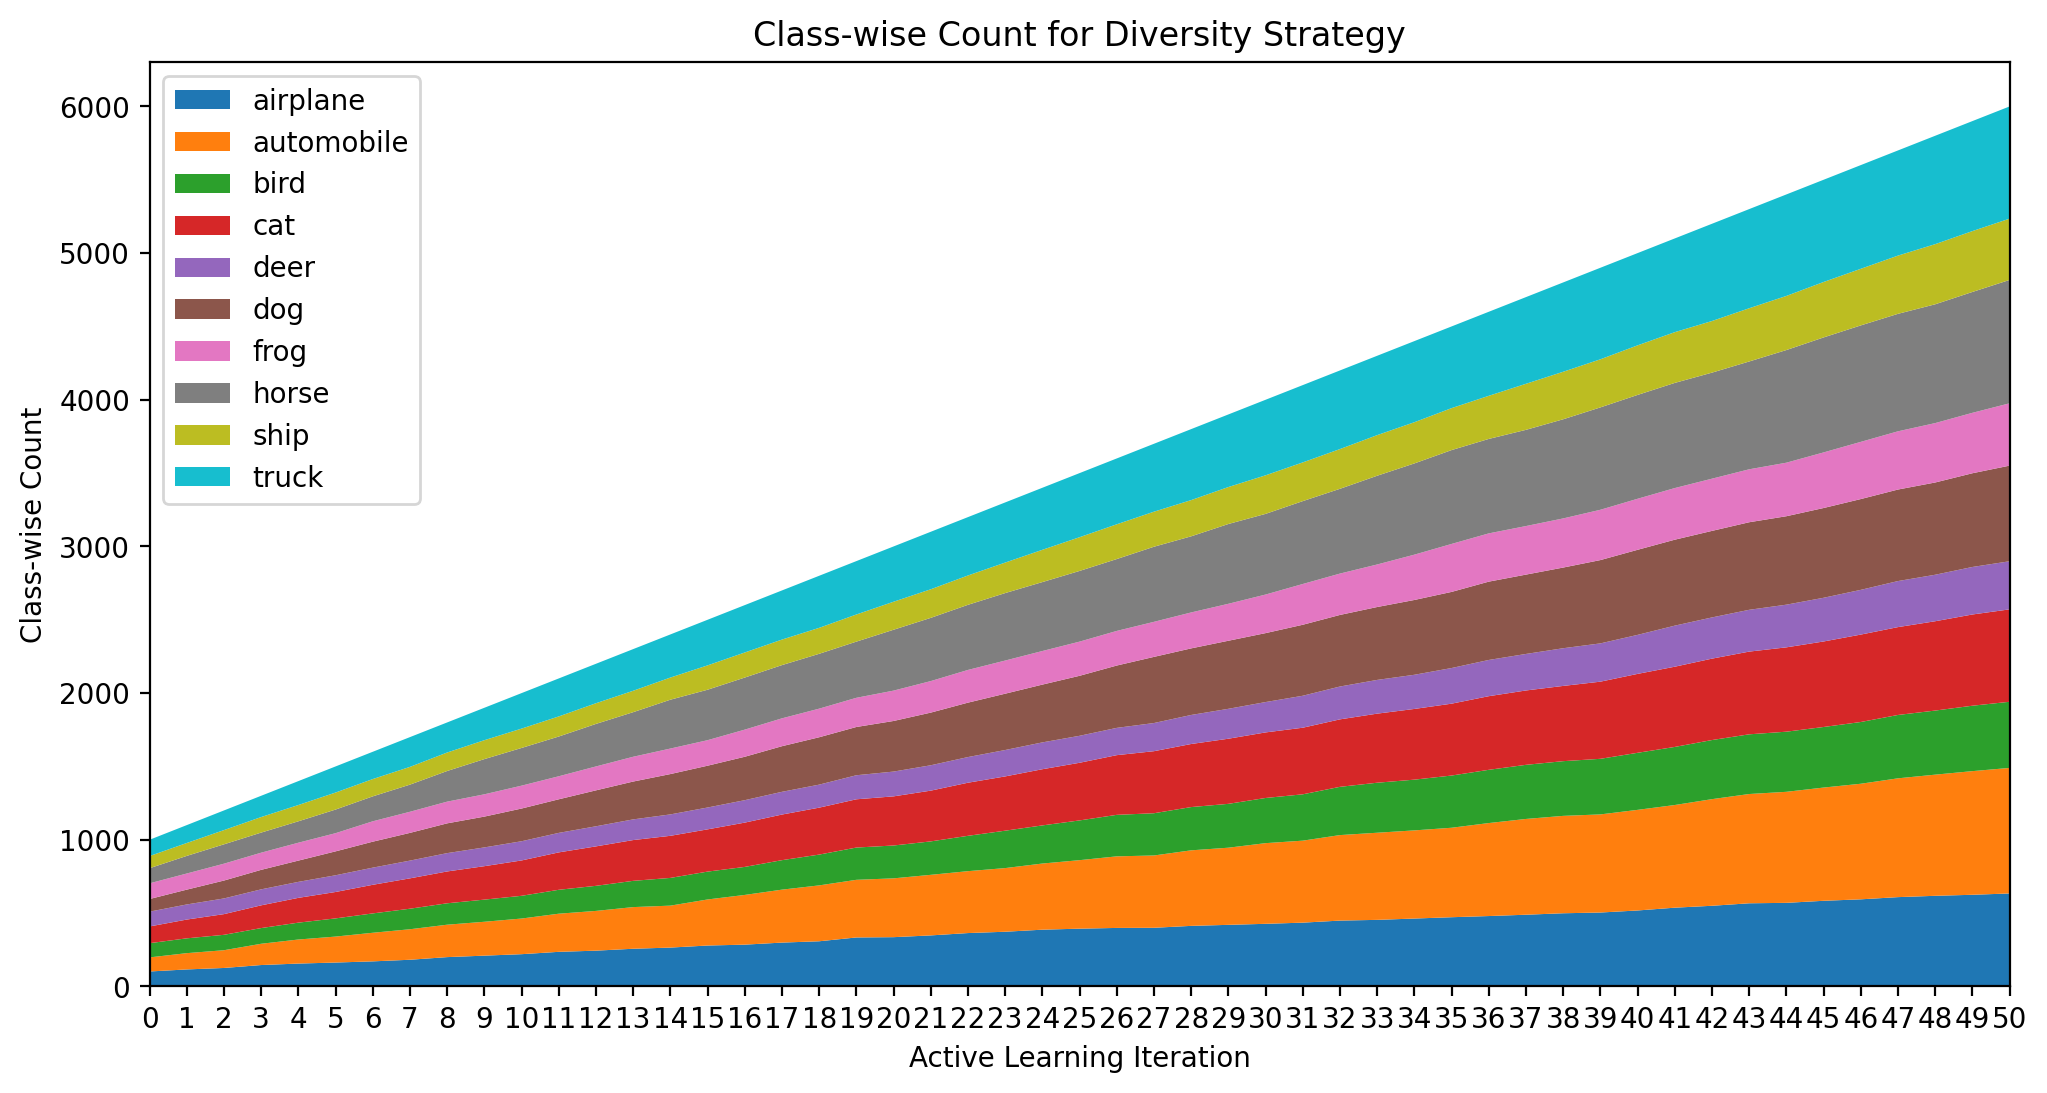

In [37]:
class_counts = class_count_dict['train_1000_pool_query_100_iter_50_DiversityStrategy_seed_0']

# Create a list of tensors from class_count_dict
class_count_tensors = [torch.tensor(count) for count in class_counts]

# Stack the tensors along dimension 1
class_count_tensor = torch.stack(class_count_tensors, dim=1)

class_count_array = class_count_tensor.cpu().numpy()

print('class_count_array shape', class_count_array.shape)
num_iter = 50
# The rest of your code for plotting
plt.figure(figsize=(12, 6)) 
plt.stackplot(range(num_iter + 1), class_count_array, labels=dataset.classes)
plt.title('Class-wise Count for Diversity Strategy')
plt.xlabel('Active Learning Iteration')
plt.ylabel('Class-wise Count')
plt.legend(loc='upper left') 
plt.xlim([1, 3])
plt.xticks(range(0, num_iter + 1))
plt.show()

class_count_array shape (10, 51)


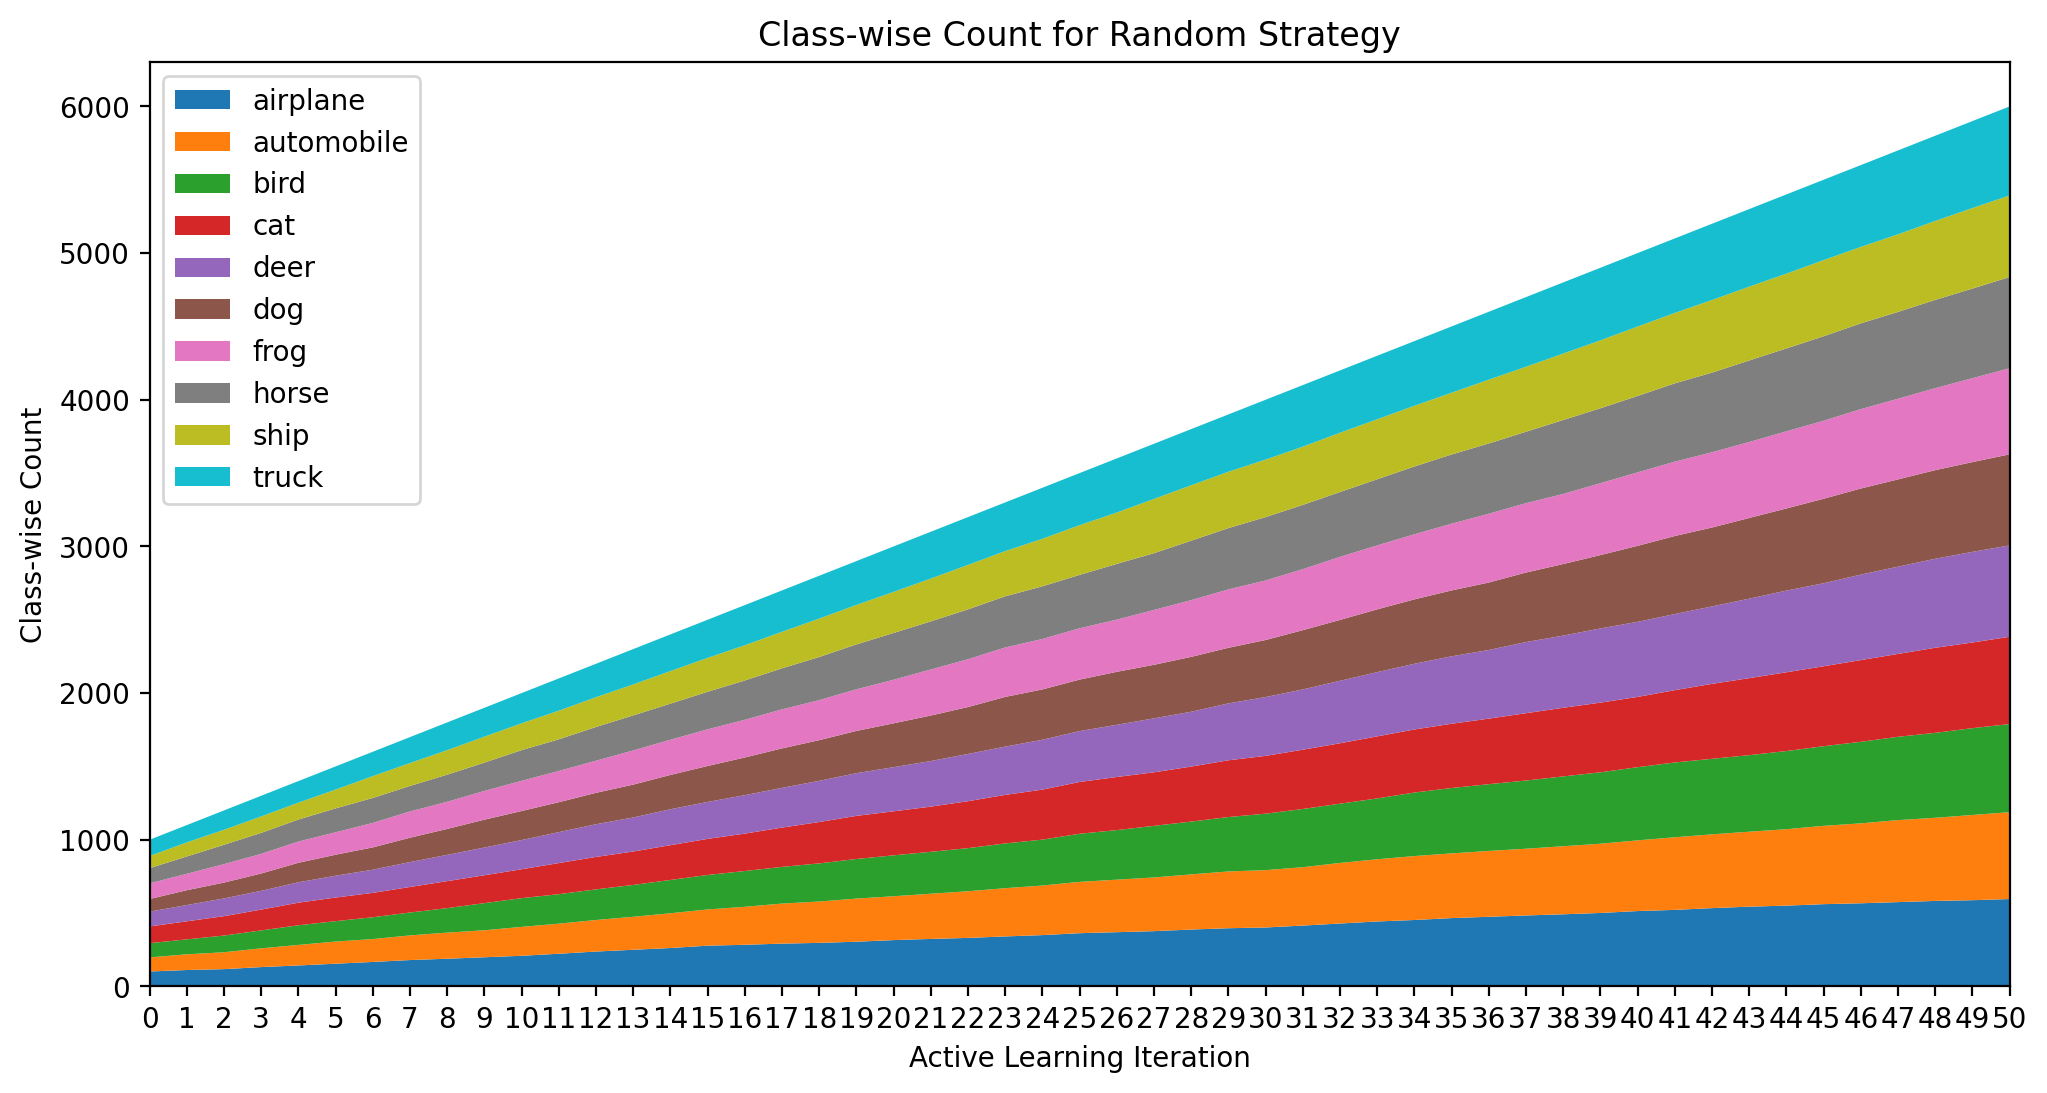

In [40]:
class_counts = class_count_dict['train_1000_pool_query_100_iter_50_RandomStrategy_seed_0']

# Create a list of tensors from class_count_dict
class_count_tensors = [torch.tensor(count) for count in class_counts]

# Stack the tensors along dimension 1
class_count_tensor = torch.stack(class_count_tensors, dim=1)

class_count_array = class_count_tensor.cpu().numpy()

print('class_count_array shape', class_count_array.shape)
num_iter = 50
# The rest of your code for plotting
plt.figure(figsize=(12, 6)) 
plt.stackplot(range(num_iter + 1), class_count_array, labels=dataset.classes)
plt.title('Class-wise Count for Random Strategy')
plt.xlabel('Active Learning Iteration')
plt.ylabel('Class-wise Count')
plt.legend(loc='upper left') 
plt.xlim([1, 3])
plt.xticks(range(0, num_iter + 1))
plt.show()

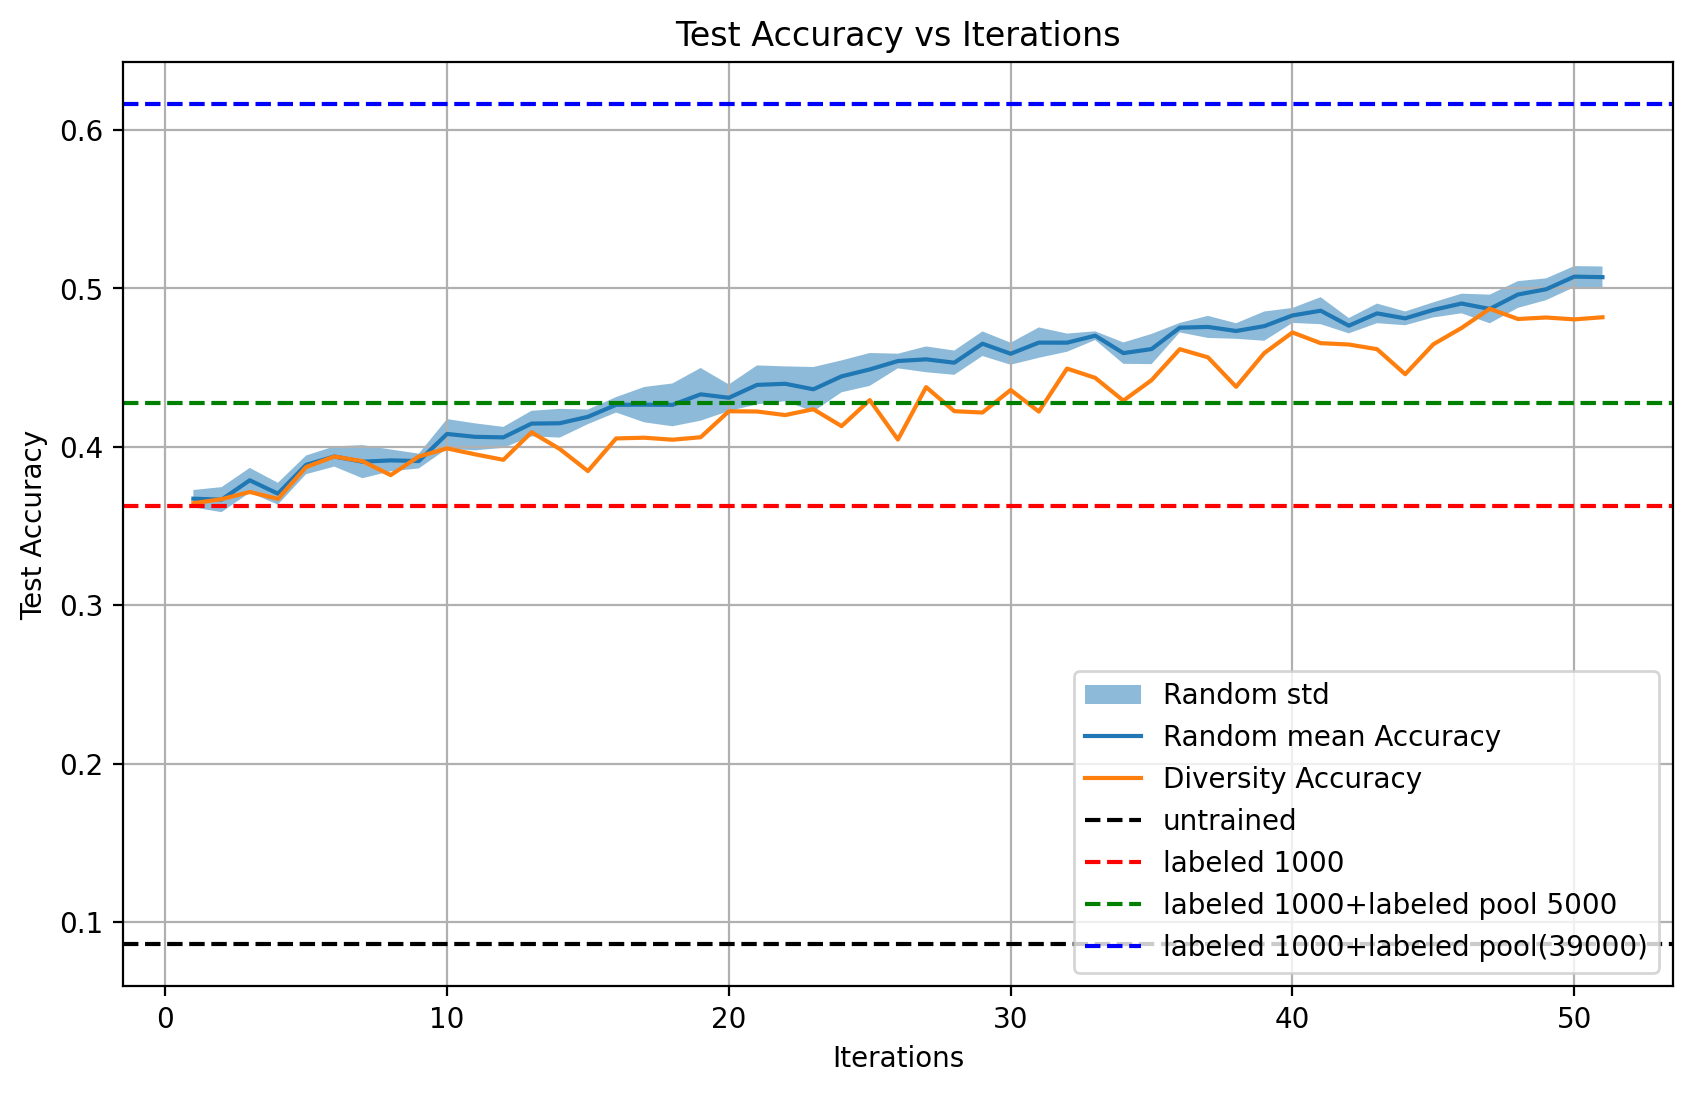

In [46]:
iterations = range(1, len(mean_test_accuracy) + 1)
plt.figure(figsize=(10, 6)) 
# Fill the region between mean - std and mean + std
plt.fill_between(iterations, np.array(mean_test_accuracy) - np.array(std_test_accuracy), np.array(mean_test_accuracy) + np.array(std_test_accuracy), alpha=0.5, label='Random std')
plt.plot(iterations, mean_test_accuracy, linestyle='-', label='Random mean Accuracy')
plt.plot(iterations, diversity_accuracy_AL_list_test, linestyle='-', label='Diversity Accuracy')
plt.axhline(y=accuracy_summary['untrain_acc']['test'], color='black', linestyle='--', label='untrained')
plt.axhline(y=accuracy_summary['train_1000']['test'], color='red', linestyle='--', label='labeled 1000')
plt.axhline(y=accuracy_summary['train_1000_pool_5000']['test'], color='green', linestyle='--', label='labeled 1000+labeled pool 5000')
# plt.axhline(y=train_1000_pool_query_100_iter_50_AL_acc.mean(), color='orange', linestyle='--', label='labeled 1000+unlabeled pool 5000 with AL')
plt.axhline(y=accuracy_summary['train_1000_pool_39000']['test'], color='blue', linestyle='--', label='labeled 1000+labeled pool(39000)')

# Customize the plot
plt.title('Test Accuracy vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

# Show the plot or save it to a file
plt.show()

# Summary of our experiments
| Experiment                                      | Accuracy on Test Set |
|-------------------------------------------------|-----------------------|
| Untrained model                                 | 8.58%              |
| Trained model on train(1000)                   | 36.24%              |
| Trained model on train(1000) + pool set(5000) random | 50.54%        |
| Trained model on train(1000) + pool set(5000) selected by AL| 48.17% |
| Trained model on train(1000) + pool set(39000) | 61.61%              |

Accuracy on test set
- Untrained model : 8.58%
- Trained model on train(1000)  : 36.24%
- Trained model on train(1000)  + pool set(5000) random: 50.54%
- Trained model on train(1000)  + pool set(5000)  unlabeled selected by AL 48.17%
  - Here we used the core-set approach to select the unlabeled data from the pool set
  - We pick 100 data points for each iteration from the pool set which are farthest from the train set for 50 such AL iterations
- Trained model on train(1000) + pool set(39000) labeled: 61.61%

all above are trained on 30 epochs. Here we can see that diveristy acquisition strategy is comparable to random acquisition strategy.